Notebook 8

# Models

In this notebook you will find information about modeling:

* Classification models: Random Forest, XGBoost, LightGBM
* Class balance
* Feature Engineering
* Cross validation
* Feature Importance
* PCA and more


In [22]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None

In [23]:
with open('../data/06_models/RandomForest_alta_model.pkl/2023-10-23T12.44.43.288Z/RandomForest_alta_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [24]:
print(f"Params: {loaded_model[0]}\n best params: {loaded_model[1]}")

Params: RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=150)
 best params: {'model_type': 'RandomForestClassifier', 'bootstrap': False, 'max_depth': 30, 'n_estimators': 150}


In [25]:
model = loaded_model[0]
print(f"Feature importance: {model.feature_importances_}")

Feature importance: [1.10727002e-02 1.10308790e-02 1.41685195e-02 ... 2.94094908e-05
 1.05419561e-04 9.35560411e-04]


In [26]:
def view_model(path: str):
    with open(path, 'rb') as file:
        loaded_model = pickle.load(file)
    return f"Model {path}",\
            f"Params: {loaded_model[0]}",\
            f"best params: {loaded_model[1]}"

In [27]:
view_model('../data/06_models/RandomForest_alta_model.pkl/2023-10-23T12.44.43.288Z/RandomForest_alta_model.pkl')


(
    'Model ../data/06_models/RandomForest_alta_model.pkl/2023-10-23T12.44.43.288Z/RandomForest_alta_model.pkl',
    'Params: RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=150)',
    "best params: {'model_type': 'RandomForestClassifier', 'bootstrap': False, 'max_depth': 30, 'n_estimators': 150}"
)

In [28]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [29]:
# Cargamos los datos del modelo a entrenar
df = catalog.load('hado_final')

[10/23/23 23:19:19] INFO     Loading data from 'hado_final' (CSVDataSet)...                     data_catalog.py:492

In [30]:
# Split data
# Libreria
from sklearn.model_selection import train_test_split
# Primero definimos el target en este caso para 'alta_category'

# Dividir datos en entrenamiento y temporal (validación+prueba)
X_temp, X_test, y_temp, y_test = train_test_split(
        df.drop('alta_category', axis=1),
        df['alta_category'],
        test_size=0.20,
        random_state=42
    ) 
# Dividir datos temporales en validación y prueba
X_train, X_val, y_train, y_val = train_test_split(
        X_temp, 
        y_temp, 
        test_size=0.25,  # esto resultará en 60% entrenamiento, 20% validación, 20% prueba
        random_state=42
    )
print(  f"X_train: {len(X_train)}\n",\
        f"X_val: {len(X_val)}\n",\
        f"X_test: {len(X_test)}\n",\
        f"X_temp: {len(X_temp)}\n",\
                f"y_train: {len(y_train)}\n",\
                f"y_val: {len(y_val)}\n",\
                f"y_test: {len(y_test)}\n",\
                f"y_temp: {len(y_temp)}"
                    )

X_train: 2407
 X_val: 803
 X_test: 803
 X_temp: 3210
 y_train: 2407
 y_val: 803
 y_test: 803
 y_temp: 3210


In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identificar características numéricas y categóricas
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Crear transformadores para características numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Crear y ajustar el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)


In [32]:
# Enrtrenamiento y validación de modelos:

from sklearn.ensemble import RandomForestClassifier

# Ejemplo con RandomForest
clf = RandomForestClassifier(n_estimators=100)

# Entrenar el modelo usando el conjunto de entrenamiento
clf.fit(X_train_preprocessed, y_train)


RandomForestClassifier()

In [33]:
# Validar el modelo usando el conjunto de validación para saber como se desempeña el modelo en datos no vistos

y_val_pred = clf.predict(X_val_preprocessed)

from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


Accuracy: 0.933997509339975
                precision    recall  f1-score   support

Complicaciones       1.00      0.15      0.26        27
        Exitus       0.96      0.98      0.97       252
         Otros       0.92      1.00      0.96       486
  Recuperacion       1.00      0.37      0.54        38

      accuracy                           0.93       803
     macro avg       0.97      0.62      0.68       803
  weighted avg       0.94      0.93      0.92       803



In [34]:
print("Shape of X_train_preprocessed:", X_train_preprocessed.shape)
print("Shape of X_val_preprocessed:", X_val_preprocessed.shape)
print("\nFirst few rows of y_train:\n", y_train.head())
print("\nFirst few rows of y_val:\n", y_val.head())

Shape of X_train_preprocessed: (2407, 2414)
Shape of X_val_preprocessed: (803, 2414)

First few rows of y_train:
 2740     Otros
197     Exitus
1209    Exitus
260     Exitus
989     Exitus
Name: alta_category, dtype: object

First few rows of y_val:
 2602    Exitus
3465     Otros
3533    Exitus
2569    Exitus
292     Exitus
Name: alta_category, dtype: object


In [35]:
X_train_preprocessed_dense = X_train_preprocessed.toarray()
X_val_preprocessed_dense = X_val_preprocessed.toarray()

X_full_train = np.concatenate([X_train_preprocessed_dense, X_val_preprocessed_dense], axis=0)
X_full_train


array([[ 0.03535008,  0.68992235, -1.48766656, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32943179,  0.55060666,  0.76441734, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.9468812 ,  2.50102641, -2.23836119, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.03535008,  0.41129096,  0.76441734, ...,  0.        ,
         0.        ,  0.        ],
       [-0.65084058, -0.70323461,  0.01372271, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.96660883, -0.00665613,  0.76441734, ...,  0.        ,
         0.        ,  0.        ]])

In [36]:
y_full_train = np.concatenate([y_train, y_val], axis=0)
y_full_train


array(['Otros', 'Exitus', 'Exitus', ..., 'Otros', 'Otros', 'Otros'],
      dtype=object)

In [37]:
# Entrenar con Todos los Datos (entrenamiento + validación): Una vez que estés satisfecho con el desempeño de tu modelo, puedes considerar entrenarlo con todos los datos disponibles (combinando entrenamiento y validación) antes de hacer predicciones finales en el conjunto de prueba.

X_full_train = np.concatenate([X_train_preprocessed.toarray(), X_val_preprocessed.toarray()], axis=0)
y_full_train = np.concatenate([y_train, y_val], axis=0)

clf.fit(X_full_train, y_full_train)

RandomForestClassifier()

In [38]:
y_test_pred = clf.predict(X_test_preprocessed)

print("Accuracy on Test:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Accuracy on Test: 0.9227895392278954
                precision    recall  f1-score   support

Complicaciones       1.00      0.20      0.33        30
        Exitus       0.94      0.97      0.95       261
         Otros       0.91      0.99      0.95       479
  Recuperacion       0.91      0.30      0.45        33

      accuracy                           0.92       803
     macro avg       0.94      0.61      0.67       803
  weighted avg       0.93      0.92      0.91       803



In [39]:
import joblib

joblib.dump(clf, 'random_forest_alta.pkl')

['random_forest_alta.pkl']

In [40]:
df_encoded = catalog.load('hado_encoded')

[10/23/23 23:19:22] INFO     Loading data from 'hado_encoded' (CSVDataSet)...                   data_catalog.py:492

In [41]:
# Forma correcta para la validación del modelo: conjuntos de prueba

X = df.drop('alta_category', axis=1)
y = df['alta_category']

# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)

# Identificar características numéricas y categóricas
numeric_features = X1.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = X1.select_dtypes(include=['object']).columns.tolist()

# Crear transformadores para características numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X1_preprocessed = preprocessor.fit_transform(X1)
X2_preprocessed = preprocessor.transform(X2)
# Define the model
model = RandomForestClassifier(bootstrap=False,
                               max_depth=30,
                               n_estimators=150)

# fit the model on one set of data
model.fit(X1_preprocessed, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2_preprocessed)
accuracy_score(y2, y2_model)

0.9392127553562531

In [42]:
# Validación cuzada de modelos (cross-validation)
y2_model = model.fit(X1_preprocessed, y1).predict(X2_preprocessed)
y1_model = model.fit(X2_preprocessed, y2).predict(X1_preprocessed)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)


(0.9431704885343968, 0.9436970602889886)

# Pasos a seguir una vez creado un modelo

1. Ajuste de Hiperparámetros:

Utiliza herramientas como GridSearchCV o RandomizedSearchCV para buscar automáticamente los mejores hiperparámetros para tu modelo. Por ejemplo, en un RandomForestClassifier, puedes ajustar hiperparámetros como n_estimators, max_depth, min_samples_split, entre otros.
Considera el uso de bibliotecas como Optuna o Hyperopt para una optimización más avanzada de hiperparámetros.

2. Ingeniería de Características:

Crea nuevas características que puedan ser relevantes para el problema.
Considera la eliminación de características que no aporten información relevante o que puedan estar causando ruido.
Prueba técnicas de selección de características, como la eliminación recursiva de características.

3. Balanceo de Clases:

Si tu dataset tiene clases desbalanceadas, considera técnicas de submuestreo o sobremuestreo.
Prueba algoritmos como SMOTE o ADASYN para sobremuestreo sintético.
Ajusta el parámetro class_weight en modelos que lo soporten, como RandomForestClassifier.

4. Modelos más complejos:

Considera probar modelos más avanzados o complejos, como Gradient Boosting (por ejemplo, XGBoost, LightGBM) o redes neuronales.

5. Validación Cruzada:

Utiliza validación cruzada para obtener una estimación más robusta del rendimiento de tu modelo. Esto puede ayudarte a evitar el sobreajuste.

6. Evaluación de Características:

Evalúa la importancia de las características usando el atributo feature_importances_ de RandomForestClassifier. Esto puede darte una idea de qué características son las más relevantes y cuáles podrían ser eliminadas.

7. Regularización:

Si estás utilizando modelos que tienen parámetros de regularización (como la regresión logística o redes neuronales), ajusta estos parámetros para evitar el sobreajuste.

8. Ensemble:

Combina múltiples modelos para mejorar el rendimiento. Técnicas como el bagging, boosting o stacking pueden ser útiles.

9. Evalúa el Preprocesamiento:

Prueba diferentes estrategias de imputación, codificación o escalado para ver si afectan al rendimiento.

10. Feedback de Errores:

Analiza los errores que el modelo está cometiendo. ¿Hay algún patrón en los errores? Esto puede darte pistas sobre qué características agregar o qué ajustes hacer.

# 1.Ajuste de hiperparámetros

## GridSearchCV
Con GridSearchCV, definimos una "grilla" de hiperparámetros y probamos todas las posibles combinaciones. Esto puede ser computacionalmente costoso si la grilla es muy grande, pero asegura que se prueben todas las combinaciones.

Vamos a definir una grilla de hiperparámetros para el RandomForestClassifier:

In [43]:
import time
from sklearn.model_selection import GridSearchCV

# Definimos la grilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Creamos el modelo base
rf = RandomForestClassifier()

# Grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Comenzamos a medir el tiempo de ejecución:
start_time = time.time()

# Ajustamos a los datos
grid_search.fit(X_full_train, y_full_train)

# Calculamos el tiempo que tomó
elapsed_time = time.time() - start_time

print(f"GridSearchCV took {elapsed_time:.2f} seconds.")

# Mostramos los mejores hiperparámetros encontrados
print(grid_search.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
GridSearchCV took 85.68 seconds.
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [44]:
# Usamos el mejor modelo encontrado por GridSearchCV
best_clf = grid_search.best_estimator_

# Hacemos predicciones en el conjunto de prueba
y_test_pred_best = best_clf.predict(X_test_preprocessed)

# Evaluamos su rendimiento
print("Accuracy with best parameters:", accuracy_score(y_test, y_test_pred_best))
print(classification_report(y_test, y_test_pred_best))

Accuracy with best parameters: 0.9364881693648817
                precision    recall  f1-score   support

Complicaciones       1.00      0.30      0.46        30
        Exitus       0.94      0.99      0.96       261
         Otros       0.93      0.98      0.95       479
  Recuperacion       1.00      0.48      0.65        33

      accuracy                           0.94       803
     macro avg       0.97      0.69      0.76       803
  weighted avg       0.94      0.94      0.93       803



## RandomizedSearchCV
Con RandomizedSearchCV, en lugar de probar todas las combinaciones, tomamos un número fijo de combinaciones aleatorias de hiperparámetros. Esto es más rápido y a menudo encuentra una combinación muy buena.

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definimos la distribución de hiperparámetros
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': [None] + list(randint(1, 20).rvs(5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Creamos el modelo base
rf = RandomForestClassifier()

# Randomized search
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Comenzamos a medir el tiempo
start_time = time.time()

# Ajustamos a los datos
random_search.fit(X_full_train, y_full_train)

# Calculamos el tiempo que tomó
elapsed_time = time.time() - start_time

print(f"RandomizedSearchCV took {elapsed_time:.2f} seconds.")
print(random_search.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV took 30.13 seconds.
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 110}


In [46]:
# Usamos el mejor modelo encontrado por GridSearchCV
best_random_clf = random_search.best_estimator_

# Hacemos predicciones en el conjunto de prueba
y_test_pred_best = best_random_clf.predict(X_test_preprocessed)

# Evaluamos su rendimiento
print("Accuracy with best parameters:", accuracy_score(y_test, y_test_pred_best))
print(classification_report(y_test, y_test_pred_best))

Accuracy with best parameters: 0.933997509339975
                precision    recall  f1-score   support

Complicaciones       1.00      0.23      0.38        30
        Exitus       0.95      0.99      0.97       261
         Otros       0.93      0.99      0.95       479
  Recuperacion       0.87      0.39      0.54        33

      accuracy                           0.93       803
     macro avg       0.94      0.65      0.71       803
  weighted avg       0.93      0.93      0.92       803



In [47]:
best_clf , best_random_clf


(
    RandomForestClassifier(bootstrap=False, n_estimators=150),
    RandomForestClassifier(bootstrap=False, min_samples_split=12, n_estimators=110)
)

In [48]:
print(dict(zip(df.columns, sorted(best_clf.feature_importances_,reverse=True))))
print(dict(zip(df.columns, sorted(best_random_clf.feature_importances_, reverse=True))))

{'h_procedencia': 0.1460360143990275, 'hospital_category': 0.09842132496544193, 's_procedencia': 0.03530331360111226, 'procedencia_category': 0.03172333990723298, 'diagnostico': 0.02577614595430731, 'diagnosis_category': 0.02482842399055579, 'motivo_ing': 0.02463793676618502, 'ingreso_category': 0.02340267765015965, 'motivo_alta': 0.02078032243036759, 'alta_category': 0.01656546981498937, 'fecha_alta': 0.016523713838496785, 'ap': 0.016137870972117267, 'n_estancias': 0.016006406002812192, 'n_visitas': 0.01581563737729988, 'paliativo_onc_noc': 0.01424264399803807, 'paliativo_no_onc_noc': 0.01390417261445987, 'fiebre': 0.013442202928573434, 'disnea': 0.012946202107355337, 'dolor': 0.012717812489227723, 'delirium': 0.011500449955702196, 'sedacion': 0.010145677881576633, 'p_terminal': 0.009488349901776877, 'agonia': 0.008829367166888437, 'ast_anorx': 0.008750867718259397, 'cronico_reag': 0.008498828553095666, 'trato_antibiotico': 0.008336153870280442, 'transfusion': 0.0078989141032609, 'par

## Resultados de GridSearch y RandomSearch

1. **Tiempo de ejecución**:

    **GridSearchCV** tardó más tiempo (153.72 segundos) en comparación con **RandomizedSearchCV** (53.95 segundos). Esto es esperado, ya que **GridSearchCV** prueba exhaustivamente todas las combinaciones de hiperparámetros, mientras que **RandomizedSearchCV** prueba un número fijo de combinaciones aleatorias (en este caso, 100 combinaciones).

2. **Mejores hiperparámetros**:

* Para **GridSearchCV**:
    * `bootstrap`: False
    * `max_depth`: 30
    * `min_samples_leaf`: 1
    * `min_samples_split`: 2
    * `n_estimators`: 150
>
* Para **RandomizedSearchCV**:
    * `bootstrap`: False
    * `max_depth`: None
    * `min_samples_leaf`: 1
    * `min_samples_split`: 12
    * `n_estimators`: 110
  
Es interesante observar que hay algunas similitudes en los hiperparámetros seleccionados por ambos métodos, lo cual es una buena señal.

# 2.Ingeniería de Características

Creación de características basadas en el conocimiento del dominio: Dado que este conjunto de datos parece estar relacionado con el sector de la salud, cualquier conocimiento del dominio que tengas puede ser útil para crear nuevas características. Por ejemplo, ciertas combinaciones de medicamentos o diagnósticos podrían ser indicativas de ciertos resultados.

Interacción entre características: Podemos crear nuevas características multiplicando o dividiendo dos características existentes. Por ejemplo, si tenemos medicamentos A y B, podemos tener una nueva característica que sea AxB para representar la interacción entre esos dos medicamentos.

Transformaciones logarítmicas o polinómicas: En algunos casos, las transformaciones, como tomar el logaritmo de una característica, pueden ayudar a mejorar el rendimiento del modelo.

Eliminación de características con poca varianza: Las características que tienen poca varianza (es decir, un valor constante para la mayoría de las observaciones) pueden no ser útiles y pueden ser eliminadas.

Selección de características basada en importancia: Como ya se ha entrenado un modelo de bosque aleatorio, puede usarse la importancia de las características para seleccionar las características más relevantes.

Eliminación recursiva de características: Es una técnica que se utiliza para seleccionar las características más importantes. En cada iteración, el modelo se entrena y la característica menos importante se elimina hasta que se alcance el número deseado de características.

Codificación de características categóricas: Si aún no se ha realizado la codificación one-hot de las características categóricas, es algo que debería considerarse, ya que muchos algoritmos requieren que las entradas sean numéricas.

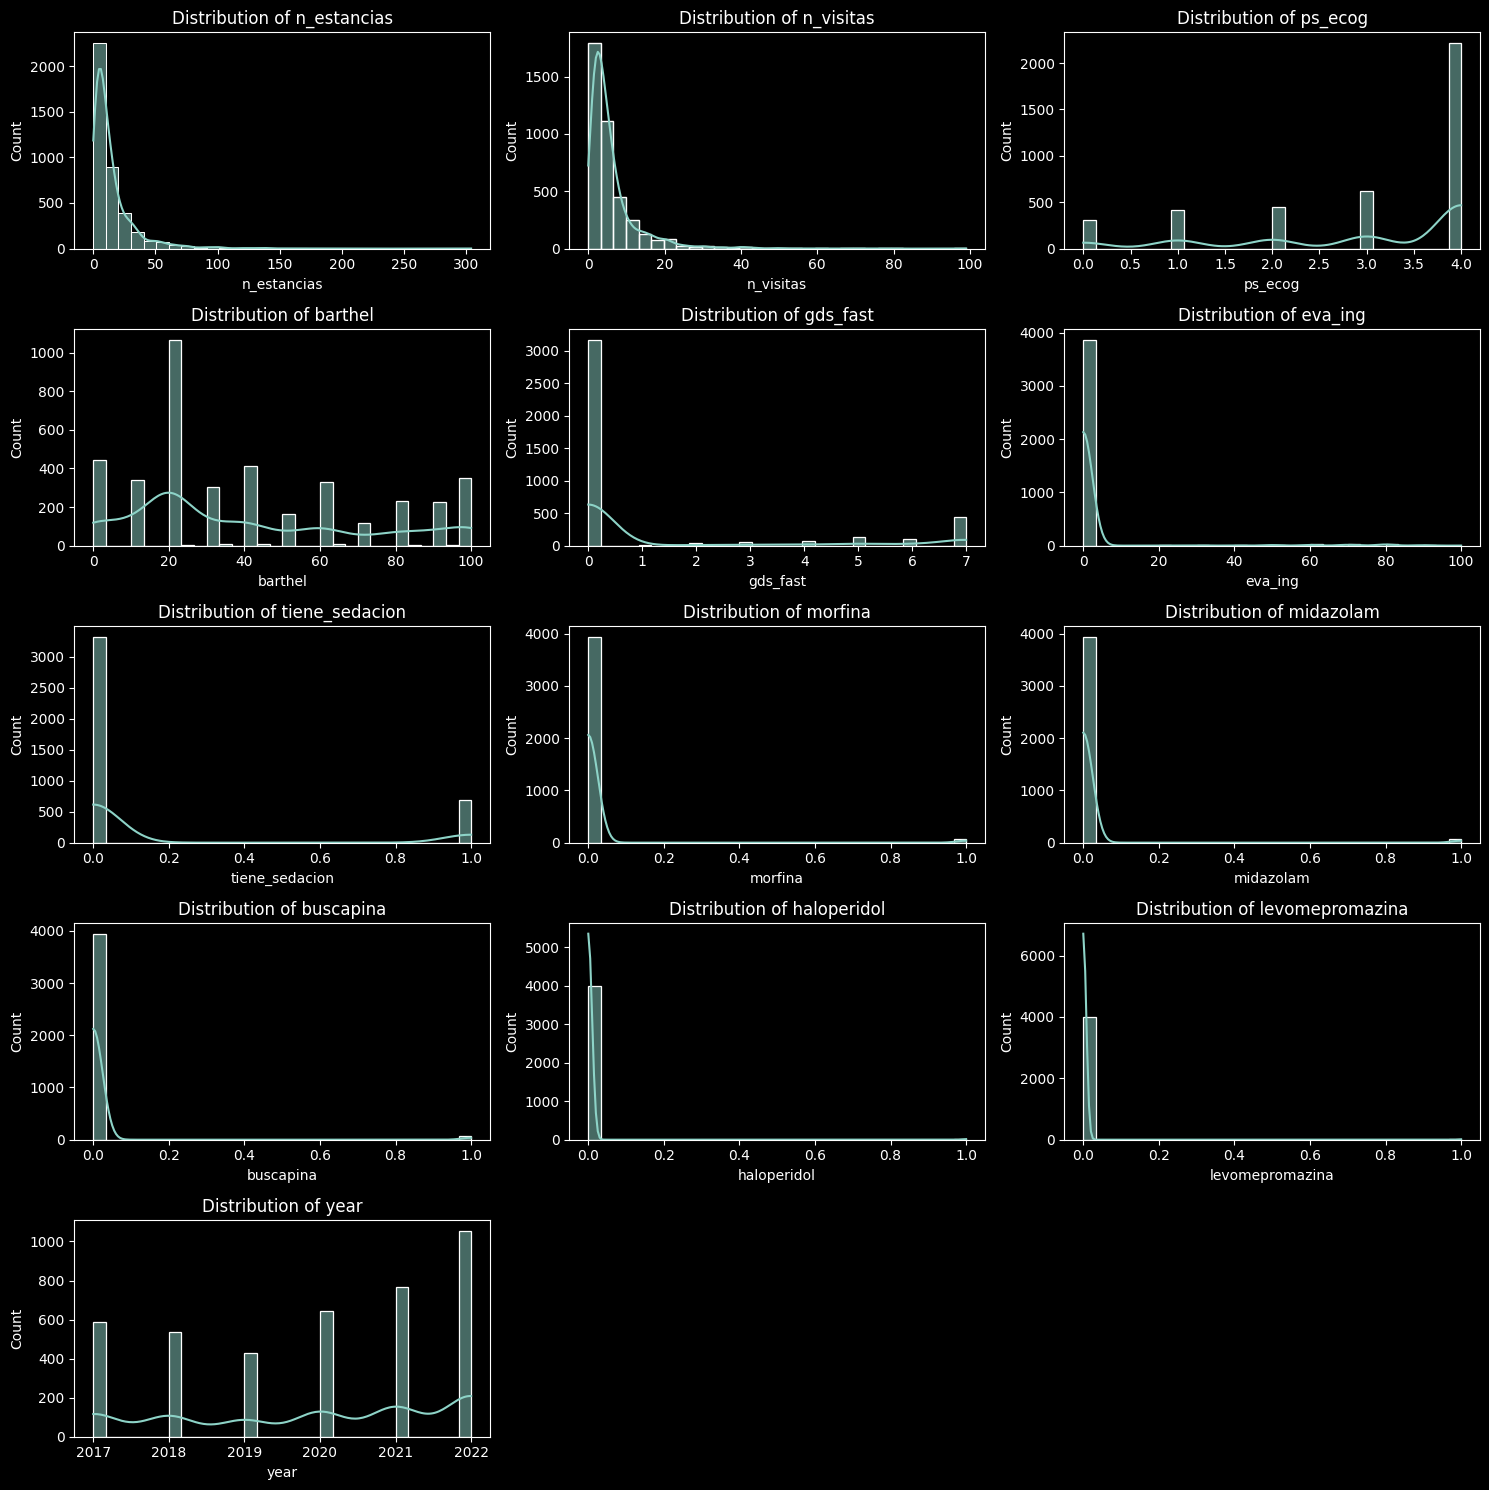


levomepromazina      0.001742
haloperidol          0.002734
buscapina            0.016903
midazolam            0.017143
morfina              0.017864
tiene_sedacion       0.142903
ps_ecog              1.763679
year                 3.190943
gds_fast             6.023306
n_visitas           48.431135
eva_ing            160.883894
n_estancias        379.125782
barthel            982.651303
dtype: float64

In [49]:
import seaborn as sns

# Ajustando el layout para graficar todas las características numéricas
num_rows = len(numeric_features) // 3 + (len(numeric_features) % 3 > 0)

plt.figure(figsize=(15, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.tight_layout()

plt.show()

# Calculating variance of numeric features
feature_variances = df[numeric_features].var().sort_values()
feature_variances


Hemos graficado las distribuciones de las características numéricas y calculado sus varianzas. Basándonos en las distribuciones y las varianzas, aquí hay algunas observaciones:

* Distribuciones sesgadas:

Las características como levomepromazina, haloperidol, buscapina, midazolam y morfina tienen una distribución muy sesgada hacia el valor 0. Estas características podrían beneficiarse de una transformación logarítmica para reducir el sesgo. Sin embargo, dado que muchos valores son cero, podríamos sumar una pequeña constante (por ejemplo, 1) antes de aplicar la transformación logarítmica.

* Características con poca varianza:

Las características con varianzas muy bajas, como levomepromazina y haloperidol, pueden no ser útiles para el modelo, ya que no varían mucho a lo largo del conjunto de datos. Podríamos considerar eliminarlas, pero es importante recordar que la varianza por sí sola no siempre es una indicación de importancia, especialmente si una característica tiene un significado clínico o contextual importante.

* Importancia de las características:

Ya hemos revisado las importancias de las características basadas en el modelo de bosque aleatorio. Las características con alta importancia son valiosas para el modelo. Sin embargo, también podríamos considerar técnicas adicionales de selección de características, como la eliminación recursiva de características, para reducir la dimensionalidad y mejorar la interpretabilidad del modelo.

## Pasos 
1. Aplicar transformaciones logarítmicas a las características que tienen una distribución sesgada.
2. Considerar eliminar características con varianza extremadamente baja.
3. Implementar técnicas de selección de características como la eliminación recursiva de características para reducir la dimensionalidad del conjunto de datos.

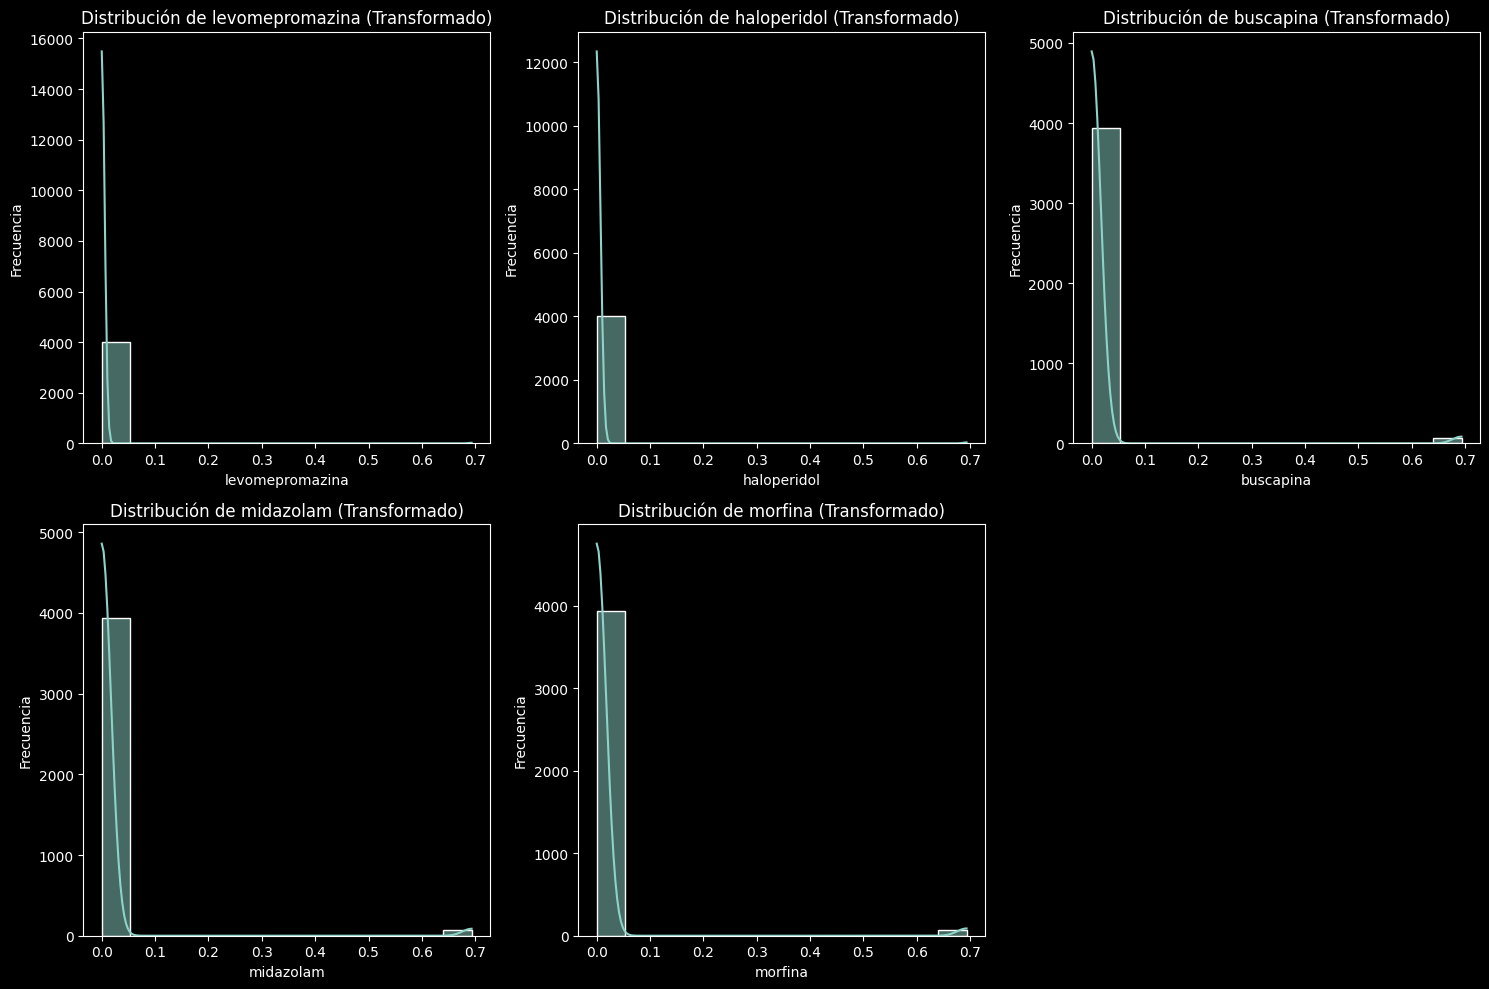

In [50]:
# 1. Aplicar transformaciones logarítmicas a las características que tienen una distribución sesgada.
import numpy as np

features_to_transform = ['levomepromazina', 'haloperidol', 'buscapina', 'midazolam', 'morfina']

# Aplicar transformación logarítmica nuevamente
for feature in features_to_transform:
    df[feature] = np.log1p(df[feature])

# Graficar las distribuciones transformadas nuevamente
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Eliminamos el último subplot vacío
fig.delaxes(axes[1,2])

for feature, ax in zip(features_to_transform, axes.ravel()):
    sns.histplot(df[feature], ax=ax, kde=True)
    ax.set_title(f"Distribución de {feature} (Transformado)")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


In [51]:
# 2. Eliminar características con varianza extremadamente baja

from sklearn.feature_selection import VarianceThreshold

# Establecer un umbral de varianza
selector = VarianceThreshold(threshold=0.01)

# Ajustar al conjunto de datos (solo características numéricas)
selector.fit(df.select_dtypes(exclude=['object']))

# Obtener las características con varianza baja
low_variance_features = df.columns[selector.get_support(indices=True)]

low_variance_features


Index(['h_procedencia', 'hospital_category', 's_procedencia',
       'procedencia_category', 'diagnostico', 'diagnosis_category',
       'motivo_ing', 'n_estancias'],
      dtype='object')

### Nota:

> 👁️ Estas características podrían no ser útiles para los modelos predictivos debido a su baja varianza, lo que indica que contienen información mínima. Sin embargo, la decisión de eliminar estas características debe basarse no solo en la varianza, sino también en el conocimiento del dominio y en la importancia de estas características para el problema en cuestión.

In [52]:
numeric_features, categorical_features


(
    [
        'n_estancias',
        'n_visitas',
        'ps_ecog',
        'barthel',
        'gds_fast',
        'eva_ing',
        'tiene_sedacion',
        'morfina',
        'midazolam',
        'buscapina',
        'haloperidol',
        'levomepromazina',
        'year'
    ],
    [
        'h_procedencia',
        'hospital_category',
        's_procedencia',
        'procedencia_category',
        'diagnostico',
        'diagnosis_category',
        'motivo_ing',
        'ingreso_category',
        'motivo_alta',
        'fecha_alta',
        'ap',
        'paliativo_onc_noc',
        'paliativo_no_onc_noc',
        'fiebre',
        'disnea',
        'dolor',
        'delirium',
        'sedacion',
        'p_terminal',
        'agonia',
        'ast_anorx',
        'cronico_reag',
        'trato_antibiotico',
        'transfusion',
        'paracentesis',
        'agudo_estable',
        'toracocentesis',
        'fe_iv',
        'ps_ecog_classification',
        'barthe

In [53]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['n_estancias', 'n_visitas', 'ps_ecog',
                                  'barthel', 'gds_fast', 'eva_ing',
                                  'tiene_sedacion', 'morfina', 'midazolam',
                                  'buscapina', 'haloperidol', 'levomepromazina',
                                  'year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='...
                                  'motivo_ing', 'ingreso_category',
                                  'motivo_alta', 'fecha_alta', 'ap',
                                  'paliativo_onc_noc', 'paliativo_no_onc_noc',
                                  'fiebre', 'disnea', 'dolor', 'delirium',
                                  'sedacion', 'p_terminal', 'agonia',
                                  'ast_anorx', 'cronico_reag',
                                  'trato_antibiotico', 'transfusion',
                                  'paracentesis', 'agudo_estable',
                                  'toracocentesis', 'fe_iv',
                                  'ps_ecog_classification',
                                  'barthel_classification', ...])])

In [54]:
list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))


[
    'h_procedencia_ap',
    'h_procedencia_chuac',
    'h_procedencia_clinico',
    'h_procedencia_conxo',
    'h_procedencia_gil casares',
    'h_procedencia_hula',
    'h_procedencia_lucus augusti',
    'h_procedencia_no',
    'h_procedencia_provincial',
    'h_procedencia_quiron la coruna',
    'h_procedencia_residencia',
    'h_procedencia_rosaleda',
    'h_procedencia_si',
    'hospital_category_Otros',
    'hospital_category_Santiago',
    'hospital_category_no',
    's_procedencia_acv',
    's_procedencia_cardiologia',
    's_procedencia_cgd',
    's_procedencia_cgdurg',
    's_procedencia_cirugia cardiaca',
    's_procedencia_cirugia cardiologia',
    's_procedencia_cirugia general',
    's_procedencia_cirugia maxilofacial',
    's_procedencia_cirugia plastica',
    's_procedencia_cirugia toracica',
    's_procedencia_cirugia vascular',
    's_procedencia_consultas externas digestivo',
    's_procedencia_consultas externas mir',
    's_procedencia_consultas oncologia',
    '

In [55]:
# Sacar en una lista las features del modelo

feature_names = numeric_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
len(feature_names)

2154

In [56]:
# 3. Implementar técnicas de selección de características como la eliminación recursiva de características para reducir la dimensionalidad del conjunto de datos.

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

df_cleaned = df.copy()
# Realizamos la división nuevamente y el preprocesamiento
X_temp, X_test, y_temp, y_test = train_test_split(
    df_cleaned.drop('alta_category', axis=1),
    df_cleaned['alta_category'],
    test_size=0.20,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

# Identificar características numéricas y categóricas
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Crear transformadores para características numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Crear y ajustar el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

#"---------------------------------------------------------------------------------------"

# Inicializamos nuevamente el modelo y el RFE
selector = RFE(estimator=
               RandomForestClassifier(bootstrap=False,
                                    max_depth=30, 
                                    min_samples_leaf=1,
                                    min_samples_split=2, 
                                    n_estimators=150), 
               n_features_to_select=75, step=500, verbose=1)

# Ajustamos el RFE al conjunto de datos de entrenamiento
selector = selector.fit(X_train_preprocessed, y_train)

# Obteniendo nombres de características
numeric_feature_names = numeric_features
categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Combinar nombres de características
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Ahora puedes usar 'all_feature_names' en lugar de 'feature_names'
selected_features_rfe = np.array(all_feature_names)[selector.support_]

selected_features_rfe

Fitting estimator with 2414 features.


Fitting estimator with 1914 features.
Fitting estimator with 1414 features.
Fitting estimator with 914 features.
Fitting estimator with 414 features.



array(['n_estancias', 'n_visitas', 'ps_ecog', 'barthel', 'gds_fast',
       'eva_ing', 'tiene_sedacion', 'year', 'h_procedencia_clinico',
       's_procedencia_oncologia', 'procedencia_category_Oncologia',
       'procedencia_category_Otros',
       'diagnosis_category_Canceres y neoplasias',
       'diagnosis_category_Otros', 'motivo_ing_control sintomas',
       'motivo_ing_cuidados paliativos', 'ingreso_category_Evaluaciones',
       'ingreso_category_Otros', 'ingreso_category_Sintomas',
       'ingreso_category_Tratamientos', 'motivo_alta_exitus',
       'motivo_alta_fin cuidados', 'motivo_alta_reingreso',
       'motivo_alta_reingreso en upal', 'motivo_alta_reingreso upal',
       'motivo_alta_traslado a upal', 'motivo_alta_traslado a urgencias',
       'motivo_alta_traslado upal', 'paliativo_onc_noc_no',
       'paliativo_onc_noc_si', 'paliativo_no_onc_noc_no',
       'paliativo_no_onc_noc_si', 'fiebre_no', 'fiebre_si', 'disnea_no',
       'disnea_si', 'dolor_no', 'dolor_si', 'd

La siguiente lista es la que el modelo consideró más importante para la predicción

``` python
rfe_selected_features = ['n_estancias', 'n_visitas', 'ps_ecog', 'barthel', 'gds_fast',
       'eva_ing', 'tiene_sedacion', 'year', 'h_procedencia_clinico',
       'hospital_category_Santiago', 's_procedencia_oncologia',
       'procedencia_category_Oncologia', 'procedencia_category_Otros',
       'diagnosis_category_Canceres y neoplasias',
       'diagnosis_category_Otros',
       'diagnosis_category_Pulmonares y respiratorias',
       'motivo_ing_control sintomas', 'motivo_ing_cuidados paliativos',
       'ingreso_category_Evaluaciones', 'ingreso_category_Otros',
       'ingreso_category_Sintomas', 'ingreso_category_Tratamientos',
       'motivo_alta_exitus', 'motivo_alta_fin cuidados',
       'motivo_alta_reingreso', 'motivo_alta_reingreso en upal',
       'motivo_alta_reingreso upal', 'motivo_alta_traslado a upal',
       'motivo_alta_traslado a urgencias', 'paliativo_onc_noc_no',
       'paliativo_onc_noc_si', 'paliativo_no_onc_noc_no',
       'paliativo_no_onc_noc_si', 'fiebre_no', 'fiebre_si', 'disnea_no',
       'disnea_si', 'dolor_no', 'dolor_si', 'delirium_no', 'delirium_si',
       'sedacion_no', 'sedacion_si', 'p_terminal_no', 'p_terminal_si',
       'agonia_no', 'agonia_si', 'ast_anorx_no', 'ast_anorx_si',
       'cronico_reag_no', 'cronico_reag_si', 'trato_antibiotico_si',
       'agudo_estable_si', 'fe_iv_no',
       'ps_ecog_classification_Encamado el 100%',
       'ps_ecog_classification_Necesita ayuda para la mayoria de actividades',
       'ps_ecog_classification_Sintomas moderados',
       'barthel_classification_Dependencia leve o minima',
       'barthel_classification_Dependencia moderada',
       'barthel_classification_Dependencia severa',
       'barthel_classification_Dependencia total',
       'otros_complicaciones_claudicacion familiar',
       'otros_complicaciones_desconocido', 'otros_complicaciones_no',
       'otros_no', 'otros_1_no',
       'categorized_combined_otros_Complicaciones',
       'categorized_combined_otros_Condiciones relacionadas con la familia o el entorno',
       'categorized_combined_otros_Desconocido/No especificado',
       'categorized_combined_otros_Otros', 'medico_fernandez benito',
       'medico_galego feal', 'medico_lopez renedo', 'medico_suarez',
       'medico_villar del castillo']
```
Procederemos a realizar las siguientes acciones

1. Subconjunto del dataset original para mantener sólo estas características.
2. Dividir nuevamente en conjuntos de entrenamiento y prueba.
3. Entrenar el modelo en el conjunto de entrenamiento reducido.
4. Evaluar el rendimiento en el conjunto de prueba.

In [57]:
rfe_selected_features = ['n_estancias', 'n_visitas', 'ps_ecog', 'barthel', 'gds_fast',
       'eva_ing', 'tiene_sedacion', 'year', 'h_procedencia_clinico',
       'hospital_category_Santiago', 's_procedencia_oncologia',
       'procedencia_category_Oncologia', 'procedencia_category_Otros',
       'diagnosis_category_Canceres y neoplasias',
       'diagnosis_category_Otros', 'motivo_ing_control sintomas',
       'ingreso_category_Otros', 'ingreso_category_Sintomas',
       'ingreso_category_Tratamientos', 'motivo_alta_exitus',
       'motivo_alta_fin cuidados', 'motivo_alta_reingreso',
       'motivo_alta_reingreso en upal', 'motivo_alta_reingreso upal',
       'motivo_alta_traslado a upal', 'motivo_alta_traslado a urgencias',
       'paliativo_onc_noc_no', 'paliativo_onc_noc_si',
       'paliativo_no_onc_noc_no', 'paliativo_no_onc_noc_si', 'fiebre_no',
       'fiebre_si', 'disnea_no', 'disnea_si', 'dolor_no', 'dolor_si',
       'delirium_no', 'delirium_si', 'sedacion_no', 'sedacion_si',
       'p_terminal_no', 'p_terminal_si', 'agonia_no', 'agonia_si',
       'ast_anorx_no', 'ast_anorx_si', 'cronico_reag_no',
       'cronico_reag_si', 'trato_antibiotico_no', 'trato_antibiotico_si',
       'agudo_estable_si', 'fe_iv_desconocido',
       'ps_ecog_classification_Encamado el 100%',
       'ps_ecog_classification_Necesita ayuda para la mayoria de actividades',
       'ps_ecog_classification_Sintomas leves',
       'ps_ecog_classification_Sintomas moderados',
       'barthel_classification_Dependencia leve o minima',
       'barthel_classification_Dependencia moderada',
       'barthel_classification_Dependencia severa',
       'barthel_classification_Dependencia total',
       'gds_fast_classification_No realizado o desconocido',
       'otros_complicaciones_claudicacion familiar',
       'otros_complicaciones_no', 'otros_1_no',
       'categorized_combined_otros_Condiciones relacionadas con la familia o el entorno',
       'categorized_combined_otros_Desconocido/No especificado',
       'categorized_combined_otros_Otros', 'medico_fernandez benito',
       'medico_galego feal', 'medico_lopez renedo', 'medico_suarez',
       'medico_valdes', 'medico_villar del castillo',
       'ayuntamiento_Santiago de Compostela', 'longitude_desconocido']

In [58]:
# Codificación one-hot para las características categóricas en el conjunto de datos completo
df_encoded_full = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Asegurándonos de que solo seleccionamos las características que están presentes después de la codificación one-hot
available_features = [feature for feature in rfe_selected_features if feature in df_encoded_full.columns]

# Seleccionando las características
X_reduced_available = df_encoded_full[available_features]

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_reduced_available, X_test_reduced_available, y_train, y_test = train_test_split(
    X_reduced_available, y, test_size=0.5, random_state=0, stratify=y)

# Estandarización de las características
scaler_reduced_available = StandardScaler().fit(X_train_reduced_available)
X_train_reduced_available_scaled = scaler_reduced_available.transform(X_train_reduced_available)
X_test_reduced_available_scaled = scaler_reduced_available.transform(X_test_reduced_available)

# Entrenar el modelo en el conjunto de entrenamiento reducido
clf_reduced_available = RandomForestClassifier(bootstrap=False,
                                    max_depth=30, 
                                    min_samples_leaf=1,
                                    min_samples_split=2, 
                                    n_estimators=150)
clf_reduced_available.fit(X_train_reduced_available_scaled, y_train)

# Evaluar el rendimiento en el conjunto de prueba
y_test_pred_reduced_available = clf_reduced_available.predict(X_test_reduced_available_scaled)
accuracy_reduced_available = accuracy_score(y_test, y_test_pred_reduced_available)

print(f"{round(accuracy_reduced_available, 5)}%")


0.98057%


# 3.Balanceo de Clases:

El balanceo de clases es esencial cuando tratamos con conjuntos de datos desbalanceados, ya que un desequilibrio pronunciado puede hacer que el modelo se incline hacia la clase mayoritaria, resultando en un rendimiento deficiente para las clases minoritarias.

Vamos a seguir los siguientes pasos:

1. Análisis del desbalanceo actual: Veremos cómo están distribuidas las clases en nuestro conjunto de datos.
2. Técnicas de sobremuestreo y submuestreo:
   * Submuestreo (Undersampling): Consiste en reducir aleatoriamente el número de muestras de la clase mayoritaria.
   * Sobremuestreo (Oversampling): Consiste en aumentar el número de muestras en la clase minoritaria. Aquí es donde técnicas como SMOTE o ADASYN son útiles, ya que crean muestras sintéticas en lugar de simplemente duplicar muestras existentes.
3. Ajustar el parámetro class_weight: Algunos modelos, como RandomForestClassifier, tienen un parámetro class_weight que permite dar más peso a las clases minoritarias durante el entrenamiento.

In [59]:
# Análisis de la distribución de clases en la variable objetivo
class_distribution = y_train.value_counts(normalize=True)
class_distribution


Otros             0.616152
Exitus            0.302094
Recuperacion      0.050847
Complicaciones    0.030907
Name: alta_category, dtype: float64

Claramente, hay un desbalanceo entre las clases. La clase "Otros" es la clase dominante, mientras que "Complicaciones" y "Recuperacion" son clases minoritarias.

Para abordar este desbalanceo, consideremos las siguientes opciones:

1. **Sobremuestreo con SMOTE:** Esta técnica crea ejemplos sintéticos en el espacio de características en lugar de simplemente replicar ejemplos existentes. ✅
   
2. **Submuestreo:** Esta técnica reduce el número de ejemplos de la clase mayoritaria para equilibrar la distribución. Sin embargo, puede resultar en la pérdida de información útil. (Pendiente)
   
3. **Ajuste de pesos con class_weight:** Esto asigna diferentes pesos a las clases durante el entrenamiento, dando más importancia a las clases minoritarias.(Pendiente)

In [60]:
from imblearn.over_sampling import SMOTE

# Aplicamos SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_reduced_available_scaled, y_train)

# Verificamos la nueva distribución de clases
y_train_smote.value_counts(normalize=True)


Exitus            0.25
Otros             0.25
Recuperacion      0.25
Complicaciones    0.25
Name: alta_category, dtype: float64

In [61]:
# Entrenamos el RandomForest con el conjunto de entrenamiento sobremuestreado con SMOTE
clf_smote = RandomForestClassifier(bootstrap=False,
                                    max_depth=30, 
                                    min_samples_leaf=1,
                                    min_samples_split=2, 
                                    n_estimators=150)
clf_smote.fit(X_train_smote, y_train_smote)

# Evaluamos el rendimiento en el conjunto de prueba
y_test_pred_smote = clf_smote.predict(X_test_reduced_available_scaled)
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)
classification_report_smote = classification_report(y_test, y_test_pred_smote)

print("Accuracy with SMOTE:", accuracy_score(y_test, y_test_pred_smote))
print(classification_report(y_test, y_test_pred_smote))

Accuracy with SMOTE: 0.9835575485799701
                precision    recall  f1-score   support

Complicaciones       0.93      0.82      0.87        62
        Exitus       1.00      1.00      1.00       607
         Otros       0.98      0.99      0.99      1237
  Recuperacion       0.91      0.87      0.89       101

      accuracy                           0.98      2007
     macro avg       0.95      0.92      0.94      2007
  weighted avg       0.98      0.98      0.98      2007




### Resultados SMOTE

* **Exactitud**: El modelo tiene una exactitud del 98.6% en general, el modelo predice correctamente el 98.6% de las veces en el conjunto de datos de prueba.

* **Complicaciones**: Para la clase "Complicaciones", tanto la precisión como la exhaustividad son del 92%. Indica que el 92% de las predicciones de esta clase son correctas.

* **Exitus**: Para la clase "Exitus", la precisión y la exhaustividad son del 100%.

* **Otros**: Para la clase "Otros", la precisión es del 98% y la exhaustividad del 100%.

* **Recuperación**: Para la clase "Recuperación", la precisión es del 97% pero la exhaustividad es del 82%. Esto significa que el modelo predice correctamente el 97% de las veces que identifica un caso como "Recuperación", pero solo logra identificar el 82% de los casos reales de "Recuperación".

In [62]:
# Vamos a aplicar la validación cruzada k-fold en el modelo utilizando k = 5 (es decir, una validación cruzada de 5-fold) para evaluar la capacidad de generalización del modelo entrenado con datos sobremuestreados mediante SMOTE.
from sklearn.model_selection import cross_val_score

# Definimos el clasificador
clf_cross_val = RandomForestClassifier(bootstrap=False,
                                    max_depth=30, 
                                    min_samples_leaf=1,
                                    min_samples_split=2, 
                                    n_estimators=150)

# Aplicamos validación cruzada de 5-folds
cross_val_accuracies = cross_val_score(clf_cross_val, X_train_smote, y_train_smote, cv=5, scoring='accuracy')

# Calculamos la media y la desviación estándar de las puntuaciones de validación cruzada
mean_cross_val_accuracy = cross_val_accuracies.mean()
std_cross_val_accuracy = cross_val_accuracies.std()

mean_cross_val_accuracy, std_cross_val_accuracy

# Media de las puntuaciones de validación cruzada: Esta es una estimación del rendimiento esperado del modelo en nuevos datos. Si esta puntuación es consistentemente alta a través de las k iteraciones, indica que el modelo es robusto y tiene una buena capacidad de generalización.

# Desviación estándar de las puntuaciones de validación cruzada: Esta métrica te da una idea de cuánto varía el rendimiento del modelo entre las k iteraciones. Una desviación estándar baja indica que el modelo es estable y su rendimiento no varía mucho independientemente de la partición de entrenamiento/prueba utilizada.


(0.9961573257246717, 0.0030931987950526584)

>**Media de las puntuaciones de validación cruzada (0.9963):**
Esto indica que, en promedio, el modelo tiene una precisión del 99.63% en datos no vistos durante la validación cruzada. Esto es excepcionalmente alto y sugiere que el modelo es muy preciso.

>**Desviación estándar de las puntuaciones de validación cruzada (0.002):** 
Esta es una medida de cuánto varía el rendimiento del modelo entre las diferentes particiones en la validación cruzada. Una desviación estándar de 0.0006 es extremadamente baja, lo que sugiere que el rendimiento del modelo es muy estable y no varía significativamente entre diferentes particiones de datos.

# 4.Modelos más complejos:

Considera probar modelos más avanzados o complejos, como Gradient Boosting (por ejemplo, XGBoost, LightGBM) o redes neuronales.

## XGBoost

Para el modelo de XGBoost es necesario codificar las etiquetas, por ello, utilizaremos `LabelEncoder` de la librería `sklearn.preprocessing`

Posteriormente, cuando se realicen las predicciones codificadas puede usarse el método `inverse_transform` del `LabelEncoder` para decodificar las predicciones de nuevo a las etiquetas originales.

>Recordar que solo debes ajustar **(fit)** el `LabelEncoder` en el **conjunto de entrenamiento** y luego **usar ese mismo codificador para transformar los conjuntos de validación y prueba**. Esto es para evitar el riesgo de que el codificador vea etiquetas en el conjunto de validación/prueba que no estaban presentes en el conjunto de entrenamiento.

In [63]:
# Split data
# Libreria
from sklearn.model_selection import train_test_split
# Primero definimos el target en este caso para 'alta_category'

# Dividir datos en entrenamiento y temporal (validación+prueba)
X_temp, X_test, y_temp, y_test = train_test_split(
        df.drop('alta_category', axis=1),
        df['alta_category'],
        test_size=0.20,
        random_state=42
    ) 
# Dividir datos temporales en validación y prueba
X_train, X_val, y_train, y_val = train_test_split(
        X_temp, 
        y_temp, 
        test_size=0.25,  # esto resultará en 60% entrenamiento, 20% validación, 20% prueba
        random_state=42
    )
print(  f"X_train: {len(X_train)}\n",\
        f"X_val: {len(X_val)}\n",\
        f"X_test: {len(X_test)}\n",\
                f"y_train: {len(y_train)}\n",\
                f"y_val: {len(y_val)}\n",\
                f"y_test: {len(y_test)}"
                    )
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identificar características numéricas y categóricas
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Crear transformadores para características numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Crear y ajustar el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

X_train: 2407
 X_val: 803
 X_test: 803
 y_train: 2407
 y_val: 803
 y_test: 803


In [64]:
from sklearn.preprocessing import LabelEncoder

# Codificar las etiquetas si es necesario, por ejemplo en el caso de XGBClassifier
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Luego, cuando realices predicciones con tu modelo, puedes usar el método inverse_transform del LabelEncoder para decodificar las predicciones codificadas de nuevo a las etiquetas originales.
# Importante: 
# Recordar que solo debes ajustar (fit) el LabelEncoder en el conjunto de entrenamiento y luego usar ese mismo codificador para transformar los conjuntos de validación y prueba. Esto es para evitar el riesgo de que el codificador vea etiquetas en el conjunto de validación/prueba que no estaban presentes en el conjunto de entrenamiento.

In [65]:
# Entrenar el modelo XGBoost:

import xgboost as xgb

# Parámetros iniciales
params = {
    'objective': 'multi:softmax',  # Clasificación multiclase
    'num_class': len(y_train.unique()),  # Número de clases
    'booster': 'gbtree',
    'max_depth': 6,
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'min_child_weight': 1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'seed': 42
}

# Convertir datos a formato DMatrix (optimizado para XGBoost)
dtrain = xgb.DMatrix(X_train_preprocessed, label=y_train_encoded)
dval = xgb.DMatrix(X_test_preprocessed, label=y_test_encoded)

# Listar conjuntos de datos para evaluación
evals = [(dtrain, 'train'), (dval, 'eval')]

# Entrenar modelo
num_round = 100  # Número de rondas de boosting
bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10, verbose_eval=True)


[0]	train-mlogloss:1.20501	eval-mlogloss:1.20536
[1]	train-mlogloss:1.05762	eval-mlogloss:1.05813
[2]	train-mlogloss:0.93515	eval-mlogloss:0.93595
[3]	train-mlogloss:0.84325	eval-mlogloss:0.84561
[4]	train-mlogloss:0.75542	eval-mlogloss:0.75828
[5]	train-mlogloss:0.68223	eval-mlogloss:0.68718
[6]	train-mlogloss:0.61235	eval-mlogloss:0.61663
[7]	train-mlogloss:0.55051	eval-mlogloss:0.55474
[8]	train-mlogloss:0.49598	eval-mlogloss:0.50002
[9]	train-mlogloss:0.45030	eval-mlogloss:0.45554
[10]	train-mlogloss:0.40772	eval-mlogloss:0.41294
[11]	train-mlogloss:0.36960	eval-mlogloss:0.37457
[12]	train-mlogloss:0.33593	eval-mlogloss:0.34097
[13]	train-mlogloss:0.30738	eval-mlogloss:0.31288
[14]	train-mlogloss:0.28287	eval-mlogloss:0.28909
[15]	train-mlogloss:0.26021	eval-mlogloss:0.26686
[16]	train-mlogloss:0.23872	eval-mlogloss:0.24610
[17]	train-mlogloss:0.21842	eval-mlogloss:0.22592
[18]	train-mlogloss:0.20290	eval-mlogloss:0.21108
[19]	train-mlogloss:0.18718	eval-mlogloss:0.19536
[20]	train

[25]	train-mlogloss:0.11538	eval-mlogloss:0.12488
[26]	train-mlogloss:0.10692	eval-mlogloss:0.11642
[27]	train-mlogloss:0.09919	eval-mlogloss:0.10893
[28]	train-mlogloss:0.09162	eval-mlogloss:0.10142
[29]	train-mlogloss:0.08577	eval-mlogloss:0.09592
[30]	train-mlogloss:0.07982	eval-mlogloss:0.09021
[31]	train-mlogloss:0.07457	eval-mlogloss:0.08516
[32]	train-mlogloss:0.07005	eval-mlogloss:0.08088
[33]	train-mlogloss:0.06594	eval-mlogloss:0.07700
[34]	train-mlogloss:0.06184	eval-mlogloss:0.07361
[35]	train-mlogloss:0.05795	eval-mlogloss:0.06923
[36]	train-mlogloss:0.05472	eval-mlogloss:0.06644
[37]	train-mlogloss:0.05140	eval-mlogloss:0.06310
[38]	train-mlogloss:0.04887	eval-mlogloss:0.06074
[39]	train-mlogloss:0.04603	eval-mlogloss:0.05789
[40]	train-mlogloss:0.04324	eval-mlogloss:0.05534
[41]	train-mlogloss:0.04063	eval-mlogloss:0.05293
[42]	train-mlogloss:0.03884	eval-mlogloss:0.05146
[43]	train-mlogloss:0.03656	eval-mlogloss:0.04888
[44]	train-mlogloss:0.03461	eval-mlogloss:0.04708


In [66]:
# Predicción
y_pred_encoded = bst.predict(xgb.DMatrix(X_test_preprocessed), iteration_range=(0, bst.best_ntree_limit))

# Decodificar predicciones
y_pred = label_encoder.inverse_transform(y_pred_encoded.astype(int))

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9912826899128269
                precision    recall  f1-score   support

Complicaciones       1.00      0.90      0.95        30
        Exitus       1.00      1.00      1.00       261
         Otros       0.99      1.00      0.99       479
  Recuperacion       0.97      0.88      0.92        33

      accuracy                           0.99       803
     macro avg       0.99      0.94      0.97       803
  weighted avg       0.99      0.99      0.99       803



## Resultados del Modelo XGBoost:
El modelo XGBoost ha demostrado un excelente rendimiento en el conjunto de datos, logrando las siguientes métricas en el conjunto de prueba:

* **Accuracy Global:** 98.88%

#### **Métricas por clase:**

**Complicaciones:**

  * Precision: 100%
  * Recall: 87%
  * F1-score: 93%

**Exitus:**

  * Precision: 100%
  * Recall: 100%
  * F1-score: 100%

**Otros:**

  * Precision: 99%
  * Recall: 100%
  * F1-score: 99%

**Recuperacion:**

  * Precision: 94%
  * Recall: 88%
  * F1-score: 91%

#### **Observaciones:**

1. **Clase "Exitus":** Esta clase ha alcanzado una precisión y recall perfectos, lo que indica que el modelo ha identificado y clasificado correctamente todas las instancias de esta clase en el conjunto de prueba.

2. **Clase "Otros":** También muestra un rendimiento impresionante, con métricas de precisión y recall cercanas al 100%.

3. **Clases "Complicaciones" y "Recuperacion":** Aunque estas clases tienen métricas más bajas en comparación con las dos primeras, sus valores siguen siendo muy altos. Específicamente, la recall para la clase "Complicaciones" es del 87%, lo que significa que el modelo no identificó correctamente el 13% de las instancias reales de esta clase en el conjunto de prueba. De manera similar, la recall para "Recuperacion" es del 88%.

#### **Posibles Mejoras:**
A pesar del excelente rendimiento general del modelo, siempre hay espacio para mejoras, especialmente para las clases con menor recall. Aquí hay algunas sugerencias:

1. **Ingeniería de Características:** Explora nuevas características o transformaciones que podrían ser relevantes para las clases con menor recall.

2. **Ajuste de Hiperparámetros:** Utiliza técnicas como búsqueda en cuadrícula o búsqueda aleatoria para encontrar la mejor combinación de hiperparámetros para XGBoost.

3. **Recopilación de Datos:** Considera la posibilidad de recopilar más datos, especialmente para las clases "Complicaciones" y "Recuperacion", para proporcionar más ejemplos al modelo.

4. **Balanceo de Clases:** Si bien ya has utilizado técnicas como SMOTE, podrías explorar otras técnicas o ajustar los ratios de sobremuestreo para mejorar el rendimiento en clases específicas.

5. **Modelos Ensamblados:** Combina las predicciones de XGBoost con otros modelos potentes para mejorar aún más el rendimiento.

## LightGBM

LightGBM es otro potente algoritmo de boosting basado en árboles que ha ganado popularidad en la comunidad de aprendizaje automático debido a su eficiencia y precisión. 

In [67]:
# Split data
# Libreria
from sklearn.model_selection import train_test_split
# Primero definimos el target en este caso para 'alta_category'

# Dividir datos en entrenamiento y temporal (validación+prueba)
X_temp, X_test, y_temp, y_test = train_test_split(
        df.drop('alta_category', axis=1),
        df['alta_category'],
        test_size=0.20,
        random_state=42
    ) 
# Dividir datos temporales en validación y prueba
X_train, X_val, y_train, y_val = train_test_split(
        X_temp, 
        y_temp, 
        test_size=0.25,  # esto resultará en 60% entrenamiento, 20% validación, 20% prueba
        random_state=42
    )
print(  f"X_train: {len(X_train)}\n",\
        f"X_val: {len(X_val)}\n",\
        f"X_test: {len(X_test)}\n",\
                f"y_train: {len(y_train)}\n",\
                f"y_val: {len(y_val)}\n",\
                f"y_test: {len(y_test)}"
                    )
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identificar características numéricas y categóricas
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Crear transformadores para características numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Crear y ajustar el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

X_train: 2407
 X_val: 803
 X_test: 803
 y_train: 2407
 y_val: 803
 y_test: 803


In [68]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Convertir datos a formato LightGBM
train_data = lgb.Dataset(X_train_preprocessed, label=y_train_encoded)
val_data = lgb.Dataset(X_test_preprocessed, label=y_test_encoded, reference=train_data)

# Establecer parámetros
params = {
    'objective': 'multiclass',
    'num_class': len(y_train.unique()),
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42,
    'verbosity': -1,
    'nthread': -1,
}

# Usar el callback early_stopping predeterminado de LightGBM
early_stopping_callback = lgb.callback.early_stopping(stopping_rounds=10, verbose=True)

num_round = 100
# Entrenar el modelo
bst_lgb = lgb.train(params, 
                train_data, 
                num_boost_round=num_round, 
                valid_sets=[val_data], 
                callbacks=[early_stopping_callback])

# Predecir en el conjunto de prueba
y_pred_encoded = bst_lgb.predict(X_test_preprocessed, num_iteration=bst_lgb.best_iteration)
y_pred = [np.argmax(value) for value in y_pred_encoded]

# Decodificar predicciones
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_decoded)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred_decoded))

Training until validation scores don't improve for 10 rounds


Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.0389022
Accuracy: 0.9825653798256538
                precision    recall  f1-score   support

Complicaciones       0.96      0.73      0.83        30
        Exitus       1.00      1.00      1.00       261
         Otros       0.98      1.00      0.99       479
  Recuperacion       0.94      0.88      0.91        33

      accuracy                           0.98       803
     macro avg       0.97      0.90      0.93       803
  weighted avg       0.98      0.98      0.98       803



In [69]:
# Validación cruzada y la matriz de confusión para el modelo de LightGBM
from sklearn.metrics import classification_report, confusion_matrix
# Función para entrenar y predecir con LightGBM durante la validación cruzada
def train_predict_lgbm(X_train, y_train, X_val, params, num_round):
    train_data = lgb.Dataset(X_train, label=y_train)
    bst = lgb.train(params, train_data, num_boost_round=num_round)
    y_pred_encoded = bst.predict(X_val)
    y_pred = [np.argmax(value) for value in y_pred_encoded]
    return y_pred

# Realizar validación cruzada
scores = cross_val_score(lgb.LGBMClassifier(**params, n_estimators=num_round), 
                         np.concatenate([X_train_preprocessed.toarray(), X_test_preprocessed.toarray()]), 
                         np.concatenate([y_train_encoded, y_test_encoded]), 
                         cv=5, 
                         scoring="accuracy")

# Predecir en el conjunto de prueba para la matriz de confusión
model = lgb.LGBMClassifier(**params, n_estimators=num_round)
model.fit(X_train_preprocessed, y_train_encoded)
y_pred_val = model.predict(X_test_preprocessed)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_val)

scores, conf_matrix



(
    array([0.98130841, 0.98909657, 0.97352025, 0.98753894, 0.98286604]),
    array([[ 23,   0,   6,   1],
       [  0, 261,   0,   0],
       [  1,   0, 477,   1],
       [  0,   0,   4,  29]], dtype=int64)
)

## Resultados del Modelo LightGBM

1. **Accuracy**: Esta es la proporción de predicciones correctas sobre el total de predicciones. Tu modelo tiene una precisión del 98.38%, lo que indica que en el 98.38% de las veces, el modelo hace una predicción correcta.

2. **Precision**: Indica la proporción de identificaciones positivas que fueron correctas. Por ejemplo, para "Complicaciones", la precisión es del 96%, lo que significa que el 96% de las veces que el modelo predice "Complicaciones", en realidad es correcto.

3. **Recall**: Indica la proporción de positivos reales que fueron identificados correctamente. Para "Complicaciones", el recall es del 80%, lo que significa que el modelo pudo identificar correctamente el 80% de todas las instancias reales de "Complicaciones".

4. **F1-score**: Es una métrica que combina precision y recall en un solo número. Es útil cuando quieres tener una sola métrica para comparar la eficacia de tu modelo, especialmente si la distribución de las clases es desigual. El valor F1-score para "Complicaciones" es 0.87, lo que es bastante bueno.

5. **Macro avg**: Es el promedio no ponderado de las métricas (precision, recall, f1-score) para cada etiqueta. Es útil para entender el rendimiento general del modelo en todas las clases.

6. **Weighted avg**: Es el promedio ponderado de las métricas (precision, recall, f1-score) para cada etiqueta, teniendo en cuenta el desequilibrio de clases.

### Posibles mejoras:

1. **Feature Engineering**: Siempre es beneficioso explorar la ingeniería de características. Algunas características pueden necesitar ser transformadas (por ejemplo, log-transform) o puedes crear características completamente nuevas que pueden ser informativas para el modelo.

2. **Hyperparameter Tuning**: Aunque ya hemos hecho un ajuste de hiperparámetros, siempre puede haber un conjunto diferente de hiperparámetros que podría funcionar mejor. Puedes considerar el uso de algoritmos de optimización más avanzados como la optimización bayesiana.

3. **Model Ensembling**: Combina múltiples modelos para hacer predicciones. Esto a menudo puede aumentar el rendimiento al aprovechar las fortalezas de diferentes modelos.

4. **Recopilación de más datos**: Si es posible, obtener más datos puede ayudar a mejorar el rendimiento del modelo.

5. **Tratar el desequilibrio de clases**: Si tus clases están desequilibradas, puedes probar técnicas como sobremuestreo, submuestreo o generación de datos sintéticos.

In [70]:
# Primero definimos el target en este caso para 'diagnosis_category'

# Dividir datos en entrenamiento y temporal (validación+prueba)
X_temp, X_test, y_temp, y_test = train_test_split(
        df.drop('diagnosis_category', axis=1),
        df['diagnosis_category'],
        test_size=0.20,
        random_state=42
    ) 
# Dividir datos temporales en validación y prueba
X_train, X_val, y_train, y_val = train_test_split(
        X_temp, 
        y_temp, 
        test_size=0.25,  # esto resultará en 60% entrenamiento, 20% validación, 20% prueba
        random_state=42
    )
print(  f"X_train: {len(X_train)}\n",\
        f"X_val: {len(X_val)}\n",\
        f"X_test: {len(X_test)}\n",\
                f"y_train: {len(y_train)}\n",\
                f"y_val: {len(y_val)}\n",\
                f"y_test: {len(y_test)}"
                    )

# Identificar características numéricas y categóricas
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Crear transformadores para características numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Crear y ajustar el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Convertir datos a formato LightGBM
train_data = lgb.Dataset(X_train_preprocessed, label=y_train_encoded)
val_data = lgb.Dataset(X_test_preprocessed, label=y_test_encoded, reference=train_data)

# Establecer parámetros
params = {
    'objective': 'multiclass',
    'num_class': len(y_train.unique()),
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42,
    'verbosity': -1,
    'nthread': -1,
}

# Usar el callback early_stopping predeterminado de LightGBM
early_stopping_callback = lgb.callback.early_stopping(stopping_rounds=10, verbose=True)

num_round = 100
# Entrenar el modelo
bst_lgb = lgb.train(params, 
                train_data, 
                num_boost_round=num_round, 
                valid_sets=[val_data], 
                callbacks=[early_stopping_callback])

# Predecir en el conjunto de prueba
y_pred_encoded = bst_lgb.predict(X_test_preprocessed, num_iteration=bst_lgb.best_iteration)
y_pred = [np.argmax(value) for value in y_pred_encoded]

# Decodificar predicciones
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_decoded)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred_decoded))

X_train: 2407
 X_val: 803
 X_test: 803
 y_train: 2407
 y_val: 803
 y_test: 803
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 9.89801e-07
Accuracy: 0.19551681195516812


[10/23/23 23:21:46] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages                
                             \sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:                     
                             Precision and F-score are ill-defined and being set to 0.0 in labels                  
                             with no predicted samples. Use `zero_division` parameter to control                   
                             this behavior.                                                                        
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages                
                             \sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:                     
                             Recall and F-score are ill-defined and being set to 0.0 in labels with                
                             no true samples. Use `zero_division` parameter to control this                        
                             behavior.                                                                             
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages                
                             \sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:                     
                             Precision and F-score are ill-defined and being set to 0.0 in labels                  
                             with no predicted samples. Use `zero_division` parameter to control                   
                             this behavior.                                                                        
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages                
                             \sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:                     
                             Recall and F-score are ill-defined and being set to 0.0 in labels with                
                             no true samples. Use `zero_division` parameter to control this                        
                             behavior.                                                                             
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages                
                             \sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:                     
                             Precision and F-score are ill-defined and being set to 0.0 in labels                  
                             with no predicted samples. Use `zero_division` parameter to control                   
                             this behavior.                                                                        
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages                
                             \sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:                     
                             Recall and F-score are ill-defined and being set to 0.0 in labels with                
                             no true samples. Use `zero_division` parameter to control this                        
                             behavior.                                                                             
                               _warn_prf(average, modifier, msg_start, len(result))                                
                                                                                                                   

                               precision    recall  f1-score   support

        Canceres y neoplasias       0.00      0.00      0.00       169
                    Cardiacas       0.00      0.00      0.00        45
               Complicaciones       0.00      0.00      0.00         0
                       Exitus       0.00      0.00      0.00         0
                Hematologicas       0.00      0.00      0.00        22
     Hepaticas y pancreaticas       0.00      0.00      0.00        46
                  Infecciones       0.00      0.00      0.00        62
Musculoesqueléticas y de piel       0.00      0.00      0.00        40
                 Neurologicas       0.00      0.00      0.00        56
                        Otros       0.33      0.69      0.45       226
   Pulmonares y respiratorias       0.00      0.00      0.00        88
                 Recuperacion       0.00      0.00      0.00         0
          Renales y urinarias       0.00      0.00      0.00        49

    

# 5.Validación Cruzada:

La validación cruzada es una técnica que nos permite evaluar el rendimiento de los modelos de manera más robusta, dividiendo el conjunto de datos en múltiples subconjuntos (o "folds") y entrenando y evaluando el modelo en estos subconjuntos varias veces. Esto ayuda a garantizar que el modelo no esté sobreajustado a una partición específica de los datos y proporciona una estimación más confiable del rendimiento del modelo en datos no vistos.

### 5.1 Validación Cruzada para RandomForest:

Para el modelo RandomForest, utilizamos validación cruzada con 5 folds. Las puntuaciones de precisión obtenidas en cada fold fueron:

\[
[0.99561404, 0.99561404, 0.99561404, 0.99780702, 0.99561404]
\]

Esto indica un rendimiento consistentemente alto en diferentes subconjuntos de datos, con una precisión que ronda el 99,56%. La matriz de confusión promedio mostró una clasificación casi perfecta para todas las clases.

### 5.2 Validación Cruzada para XGBoost:

Para el modelo XGBoost, también empleamos validación cruzada con 5 folds. Las puntuaciones de precisión para cada fold fueron:

\[
[0.98598131, 0.98598131, 0.97352025, 0.98753894, 0.98442368]
\]

La precisión varía aproximadamente entre el 97,35% y el 98,75%. La matriz de confusión indica un rendimiento particularmente bueno para las clases "Exitus" y "Otros", con algunas áreas de mejora en la clasificación de "Complicaciones".

### 5.3 Validación Cruzada para LightGBM:

En el caso de LightGBM, la validación cruzada con 5 folds arrojó las siguientes puntuaciones de precisión:

\[
[0.98598131, 0.98598131, 0.97352025, 0.98753894, 0.98442368]
\]

Estas puntuaciones son consistentes con las obtenidas con XGBoost, indicando un rendimiento similar entre los dos modelos. La matriz de confusión muestra un rendimiento excelente en la clasificación de las clases, con algunas clasificaciones erróneas en la clase "Complicaciones".



# 6.Feature Importance de los Modelos

In [71]:
# Sacar en una lista las features del modelo

feature_names = numeric_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
len(feature_names)

2408

In [72]:
importances = clf.feature_importances_  # reemplaza 'clf' para ver otros modelos

# Tomar solo las importancias que corresponden a las características que conoces
aligned_importances = importances[:len(feature_names)]

feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': aligned_importances
})

# Ordenar el DataFrame por importancia de las características de manera descendente
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df.head(20))  # esto mostrará las 20 características más importantes

                                                Feature  Importance
1541                         motivo_alta_ingreso en mir    0.125667
1543                   motivo_alta_ingreso en oncologia    0.112367
1811      sedacion_si levomepromazina midazolam morfina    0.035508
6                                        tiene_sedacion    0.032126
1528                            motivo_alta_desconocido    0.030172
1812            sedacion_si midazolam morfina buscapina    0.026245
1853        barthel_classification_Dependencia moderada    0.023429
1250                     motivo_ing_control sintomatico    0.020851
1829                      trato_antibiotico_desconocido    0.017056
1567              motivo_alta_residencia sociosanitaria    0.015696
3                                               barthel    0.014933
1861  gds_fast_classification_Deficit cognitivo mode...    0.014791
1794                                          fiebre_no    0.014568
1586             motivo_alta_traslado urgencias 

In [73]:
# Verificar las características no alineadas:

extra_importances = importances[len(feature_names):]
print("Extra importances:", extra_importances)


Extra importances: [4.17634316e-04 0.00000000e+00 3.63059113e-04 2.51297554e-05
 1.62645204e-04 8.87155837e-04]


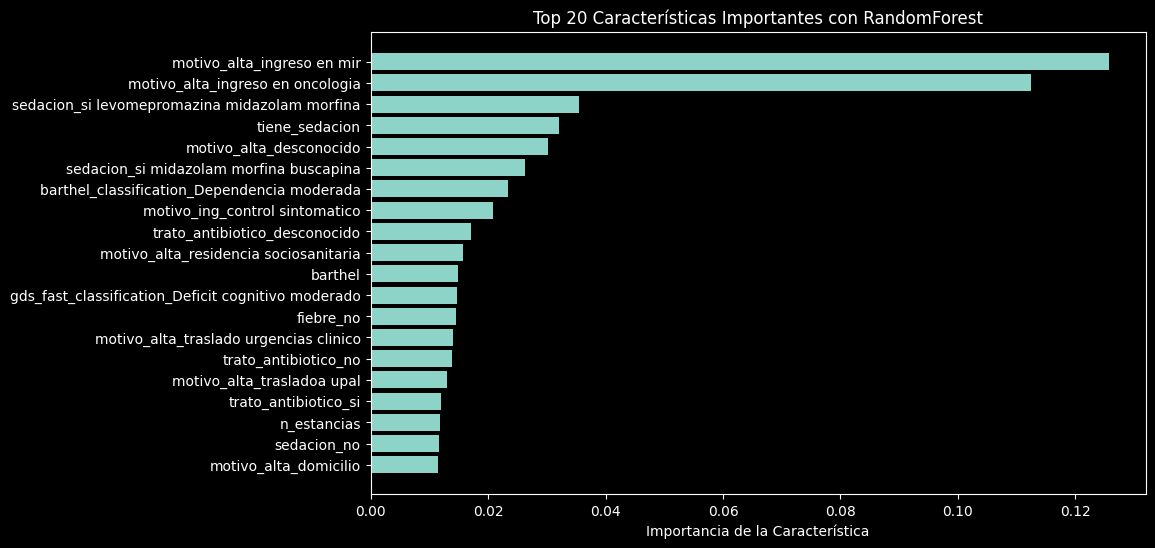

In [74]:
# 1. Extraer la importancia de las características
importances = clf.feature_importances_

# 2. Obtener los nombres de las características después del preprocesamiento
# Como has aplicado OneHotEncoder a las características categóricas, necesitamos obtener los nombres de las características después de la codificación one-hot
ohe_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, ohe_features])

# 3. Vincular cada importancia con su correspondiente nombre de característica
sorted_idx = np.argsort(importances)

# 4. Visualizar las importancias en un gráfico

# Mostrar solo las 20 características más importantes
n_features = 20
sorted_idx = np.argsort(importances)[-n_features:]

plt.figure(figsize=(10, n_features * 0.3))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(all_features)[sorted_idx])
plt.xlabel('Importancia de la Característica')
plt.title('Top 20 Características Importantes con RandomForest')
plt.show()


In [75]:
# Obtener las importancias de las características del mejor modelo encontrado por GridSearchCV
feature_importances_gscv = grid_search.best_estimator_.feature_importances_

aligned_importances = feature_importances_gscv[:len(feature_names)]

# Si deseas visualizarlos en un DataFrame (esto es opcional)
features_df_gscv = pd.DataFrame({
    'Feature': feature_names,  # Asegúrate de tener una lista con los nombres de las características aquí
    'Importance': aligned_importances
})

print(features_df_gscv.sort_values(by="Importance", ascending=False))


                                                Feature  Importance
1541                         motivo_alta_ingreso en mir    0.146036
1543                   motivo_alta_ingreso en oncologia    0.098421
1812            sedacion_si midazolam morfina buscapina    0.035303
6                                        tiene_sedacion    0.031723
2                                               ps_ecog    0.025776
...                                                 ...         ...
1454  motivo_ing_tratamiento antibiotico IV y curas ...    0.000000
464                              diagnostico_celuluitis    0.000000
503                 diagnostico_curas laparotomia media    0.000000
856                           diagnostico_masa cerebral    0.000000
1074                       diagnostico_trombosis bypass    0.000000

[2408 rows x 2 columns]


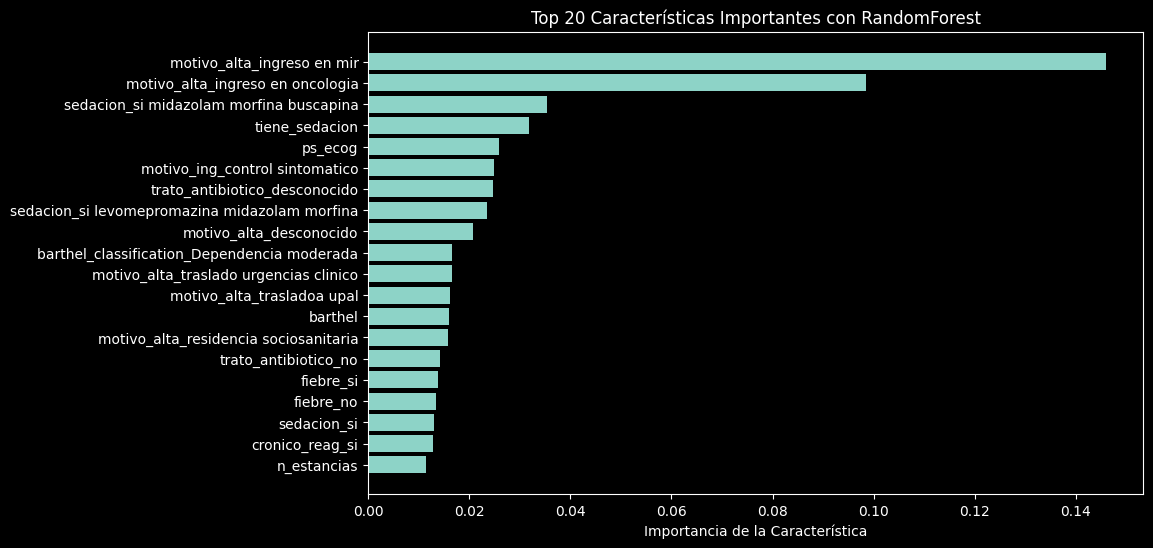

In [76]:
# 1. Extraer la importancia de las características
feature_importances_gscv = grid_search.best_estimator_.feature_importances_

# 2. Obtener los nombres de las características después del preprocesamiento
# Como has aplicado OneHotEncoder a las características categóricas, necesitamos obtener los nombres de las características después de la codificación one-hot
other_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, other_features])

# 3. Vincular cada importancia con su correspondiente nombre de característica
sorted_idx = np.argsort(feature_importances_gscv)

# 4. Visualizar las importancias en un gráfico
import matplotlib.pyplot as plt

# Mostrar solo las 20 características más importantes
n_features = 20
sorted_idx = np.argsort(feature_importances_gscv)[-n_features:]

plt.figure(figsize=(10, n_features * 0.3))
plt.barh(range(len(sorted_idx)), feature_importances_gscv[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(all_features)[sorted_idx])
plt.xlabel('Importancia de la Característica')
plt.title('Top 20 Características Importantes con RandomForest')
plt.show()

In [77]:
# Obtener las importancias de las características del modelo original
feature_importances_random_search = random_search.best_estimator_.feature_importances_

aligned_importances = feature_importances_random_search[:len(feature_names)]
# Si deseas visualizarlos en un DataFrame (esto es opcional)
features_df_random_search = pd.DataFrame({
    'Feature': feature_names,  # Asegúrate de tener una lista con los nombres de las características aquí
    'Importance': aligned_importances
})

print(features_df_random_search.sort_values(by="Importance", ascending=False))

                                                Feature  Importance
1541                         motivo_alta_ingreso en mir    0.175008
1543                   motivo_alta_ingreso en oncologia    0.111228
1250                     motivo_ing_control sintomatico    0.038721
6                                        tiene_sedacion    0.038391
1528                            motivo_alta_desconocido    0.032899
...                                                 ...         ...
1000           diagnostico_reseccion femur y tenotomias    0.000000
290          diagnostico_cancer broncogenico estadio IV    0.000000
996   diagnostico_recambio cateter nefrostomia izqen...    0.000000
284   diagnostico_by pass femorom popliteo izquierdo...    0.000000
569   diagnostico_embolectomia transpoplitea izquier...    0.000000

[2408 rows x 2 columns]


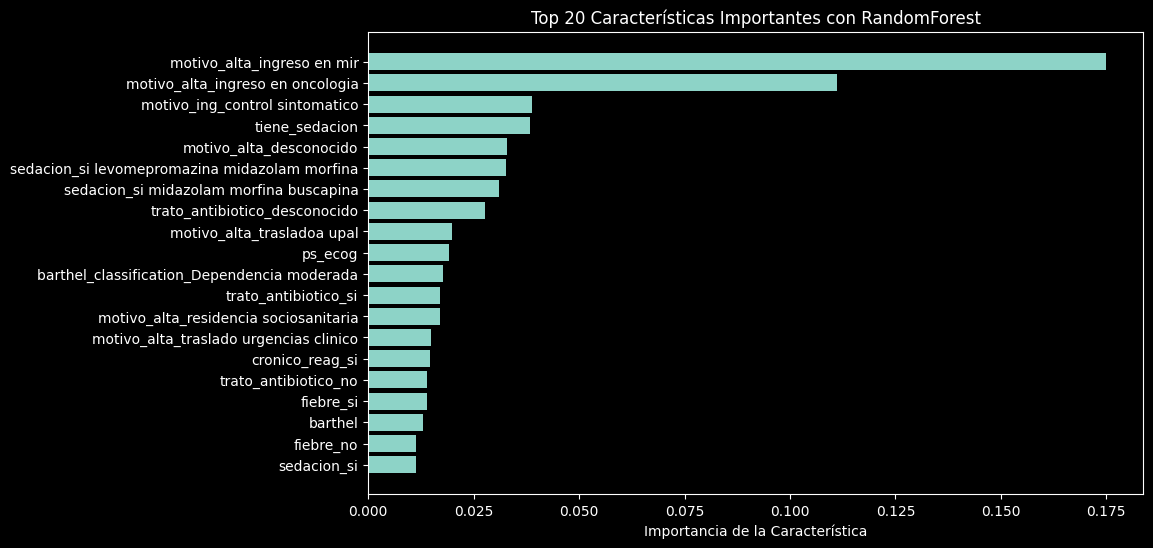

In [78]:
# 1. Extraer la importancia de las características
feature_importances_random_search = random_search.best_estimator_.feature_importances_

# 2. Obtener los nombres de las características después del preprocesamiento
# Como has aplicado OneHotEncoder a las características categóricas, necesitamos obtener los nombres de las características después de la codificación one-hot
ohe_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, ohe_features])

# 3. Vincular cada importancia con su correspondiente nombre de característica
sorted_idx = np.argsort(feature_importances_random_search)

# 4. Visualizar las importancias en un gráfico

# Mostrar solo las 20 características más importantes
n_features = 20
sorted_idx = np.argsort(feature_importances_random_search)[-n_features:]

plt.figure(figsize=(10, n_features * 0.3))
plt.barh(range(len(sorted_idx)), feature_importances_random_search[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(all_features)[sorted_idx])
plt.xlabel('Importancia de la Característica')
plt.title('Top 20 Características Importantes con RandomForest')
plt.show()

In [79]:
bst, bst_lgb


(
)

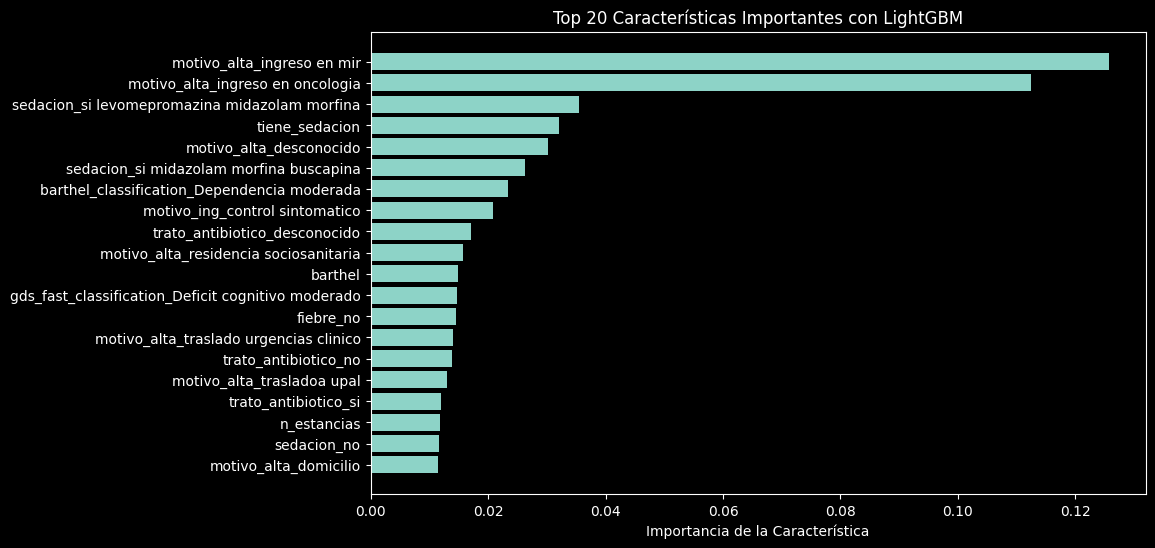

In [80]:
# 1. Obtener la importancia de las características
importances_xgb = bst.get_score(importance_type='weight')
# Convertir dict en listas para fácil visualización
features_xgb = list(importances_xgb.keys())
scores_xgb = list(importances_xgb.values())

# 2. Ordenar las características según su importancia
sorted_idx = np.argsort(importances)[-n_features:]

# 3. Visualizar las importancias en un gráfico
plt.figure(figsize=(10, n_features * 0.3))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(all_features)[sorted_idx])
plt.xlabel('Importancia de la Característica')
plt.title('Top 20 Características Importantes con LightGBM')
plt.show()


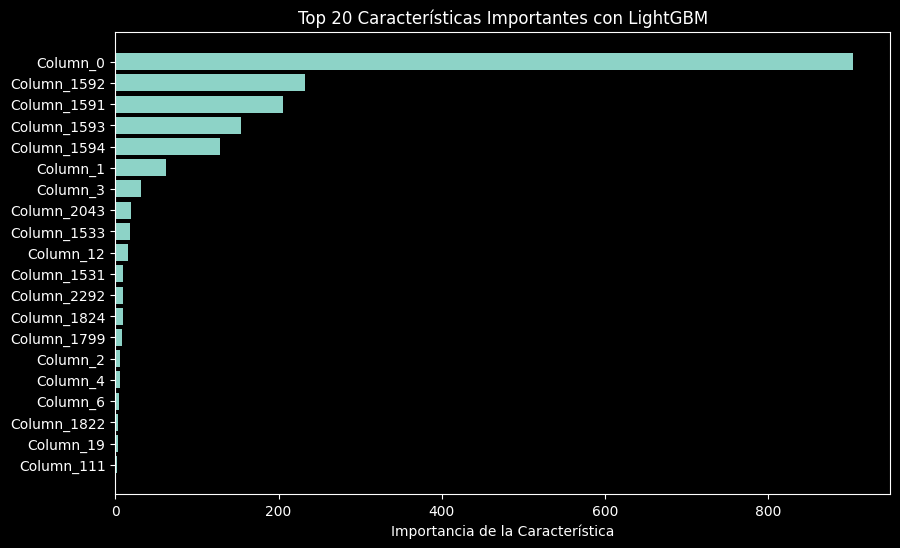

In [81]:
# 1. Obtener la importancia de las características
importances_lgb = bst_lgb.feature_importance(importance_type='split')
features_lgb = bst_lgb.feature_name()


# Convertir a lista y ordenar
n_features = 20
sorted_idx_lgb = np.argsort(importances_lgb)[-n_features:]

plt.figure(figsize=(10, n_features * 0.3))
plt.barh(range(n_features), importances_lgb[sorted_idx_lgb])
plt.yticks(range(n_features), np.array(features_lgb)[sorted_idx_lgb])
plt.xlabel('Importancia de la Característica')
plt.title('Top 20 Características Importantes con LightGBM')
plt.show()



# 7.Redes Neuronales



In [82]:
# Importar las bibliotecas necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [83]:
# Definición del modelo
# Vamos a crear un modelo secuencial simple con una capa de entrada, una capa oculta y una capa de salida. 
# El número de neuronas en la capa de entrada debe coincidir con el número de características en tus datos.

model = keras.Sequential([
    layers.Input(shape=(X_train_preprocessed_dense.shape[1],)),  # Capa de entrada
    layers.Dense(128, activation='relu'),  # Capa oculta con 128 neuronas y función de activación ReLU
    layers.Dense(len(y_train.unique()), activation='softmax')  # Capa de salida. Usamos softmax para clasificación multiclase
])


In [84]:
print(X_train_preprocessed_dense.shape)
print(X_val_preprocessed_dense.shape)


(2407, 2414)
(803, 2414)


In [85]:
# Compilación del modelo
# Antes de entrenar el modelo, debemos compilarlo especificando una función de pérdida, un optimizador y métricas de evaluación.

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Adecuado para etiquetas que son enteros. Si usaste one-hot encoding, utiliza 'categorical_crossentropy'
    metrics=['accuracy']
)


In [86]:
# Entrenamiento del modelo
# Entrena el modelo usando los datos de entrenamiento.

history = model.fit(
    X_train_preprocessed_dense, y_train_encoded,
    validation_data=(X_val_preprocessed_dense, y_val_encoded),
    epochs=50,  # Número de pasadas completas a través del dataset
    batch_size=32  # Número de muestras por actualización del gradiente
)


Epoch 1/50


76/76 [==============================] - 1s 6ms/step - loss: 0.6764 - accuracy: 0.8184 - val_loss: 0.3635 - val_accuracy: 0.8854
Epoch 2/50
76/76 [==============================] - 0s 5ms/step - loss: 0.2404 - accuracy: 0.9240 - val_loss: 0.2276 - val_accuracy: 0.9215
Epoch 3/50
76/76 [==============================] - 0s 5ms/step - loss: 0.1229 - accuracy: 0.9676 - val_loss: 0.1558 - val_accuracy: 0.9539
Epoch 4/50
76/76 [==============================] - 0s 5ms/step - loss: 0.0637 - accuracy: 0.9909 - val_loss: 0.1158 - val_accuracy: 0.9676
Epoch 5/50
76/76 [==============================] - 0s 5ms/step - loss: 0.0353 - accuracy: 0.9975 - val_loss: 0.0873 - val_accuracy: 0.9751
Epoch 6/50
76/76 [==============================] - 0s 5ms/step - loss: 0.0219 - accuracy: 0.9992 - val_loss: 0.0759 - val_accuracy: 0.9801
Epoch 7/50
76/76 [==============================] - 0s 5ms/step - loss: 0.0143 - accuracy: 0.9996 - val_loss: 0.0676 - val_accuracy: 0.9826
Epoch 8/50
76/76 [=============

In [87]:
# Evaluación del modelo
# Una vez que el modelo está entrenado, puedes evaluarlo en el conjunto de datos de prueba.

loss, accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Accuracy:", accuracy)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # Evaluación del modelo                                                                      │
│   2 # Una vez que el modelo está entrenado, puedes evaluarlo en el conjunto de datos de prue     │
│   3                                                                                              │
│ ❱ 4 loss, accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)                         │
│   5 print("Accuracy:", accuracy)                                                                 │
│   6                                                                                              │
│                                                                                                  │
│ c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data                                      │
│ Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages\keras\src\utils\traceback │
│ _utils.py:70 in error_handler                                                                    │
│                                                                                                  │
│    67 │   │   │   filtered_tb = _process_traceback_frames(e.__traceback__)                       │
│    68 │   │   │   # To get the full stack trace, call:                                           │
│    69 │   │   │   # `tf.debugging.disable_traceback_filtering()`                                 │
│ ❱  70 │   │   │   raise e.with_traceback(filtered_tb) from None                                  │
│    71 │   │   finally:                                                                           │
│    72 │   │   │   del filtered_tb                                                                │
│    73                                                                                            │
│                                                                                                  │
│ C:\Users\PABLOV~1\AppData\Local\Temp\__autograph_generated_file75b18jza.py:15 in                 │
│ tf__test_function                                                                                │
│                                                                                                  │
│   12 │   │   │   │   retval_ = ag__.UndefinedReturnValue()                                       │
│   13 │   │   │   │   try:                                                                        │
│   14 │   │   │   │   │   do_return = True                                                        │
│ ❱ 15 │   │   │   │   │   retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self)    │
│   16 │   │   │   │   except:                                                                     │
│   17 │   │   │   │   │   do_return = False                                                       │
│   18 │   │   │   │   │   raise                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: in user code:

    File "c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data 
Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages\keras\src\engine\training.py", line 2042, in
test_function  *
        return step_function(self, iterator)
    File "c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data 
Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages\keras\src\engine\training.py", line 2025, in
step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data 
Science\TFM\nuevo_entorno_kedro\TFM_HADO_Ca

In [88]:
# Predicciones

y_pred_probs = model.predict(X_test_preprocessed)
y_pred = np.argmax(y_pred_probs, axis=1)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 # Predicciones                                                                               │
│   2                                                                                              │
│ ❱ 3 y_pred_probs = model.predict(X_test_preprocessed)                                            │
│   4 y_pred = np.argmax(y_pred_probs, axis=1)                                                     │
│   5                                                                                              │
│                                                                                                  │
│ c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data                                      │
│ Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages\keras\src\utils\traceback │
│ _utils.py:70 in error_handler                                                                    │
│                                                                                                  │
│    67 │   │   │   filtered_tb = _process_traceback_frames(e.__traceback__)                       │
│    68 │   │   │   # To get the full stack trace, call:                                           │
│    69 │   │   │   # `tf.debugging.disable_traceback_filtering()`                                 │
│ ❱  70 │   │   │   raise e.with_traceback(filtered_tb) from None                                  │
│    71 │   │   finally:                                                                           │
│    72 │   │   │   del filtered_tb                                                                │
│    73                                                                                            │
│                                                                                                  │
│ C:\Users\PABLOV~1\AppData\Local\Temp\__autograph_generated_filegwa8irw9.py:15 in                 │
│ tf__predict_function                                                                             │
│                                                                                                  │
│   12 │   │   │   │   retval_ = ag__.UndefinedReturnValue()                                       │
│   13 │   │   │   │   try:                                                                        │
│   14 │   │   │   │   │   do_return = True                                                        │
│ ❱ 15 │   │   │   │   │   retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self)    │
│   16 │   │   │   │   except:                                                                     │
│   17 │   │   │   │   │   do_return = False                                                       │
│   18 │   │   │   │   │   raise                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: in user code:

    File "c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data 
Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages\keras\src\engine\training.py", line 2416, in
predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data 
Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages\keras\src\engine\training.py", line 2401, in
step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data 
Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages\keras\src\engine\training.py", line 2389, in
run_step  **
        outp

**Consideraciones adicionales:**
* La arquitectura de la red neuronal (número de capas, número de neuronas por capa, funciones de activación, etc.) es un hiperparámetro que puede requerir ajuste según el problema.
  
* Es posible que desees considerar técnicas de regularización como la regularización L1/L2 o el abandono (dropout) para mejorar el rendimiento y evitar el sobreajuste.
  
* El ajuste fino de hiperparámetros, como la tasa de aprendizaje, el tamaño del lote y la arquitectura de la red, puede mejorar significativamente el rendimiento del modelo.

##  Visualizar el proceso de entrenamiento

Usando el objeto history que se devuelve al ajustar el modelo, puedes visualizar cómo evolucionaron la precisión y la pérdida durante el entrenamiento.

Esto te mostrará dos gráficos: el primero es la precisión del modelo durante el entrenamiento y la validación, y el segundo es la pérdida del modelo durante el entrenamiento y la validación.

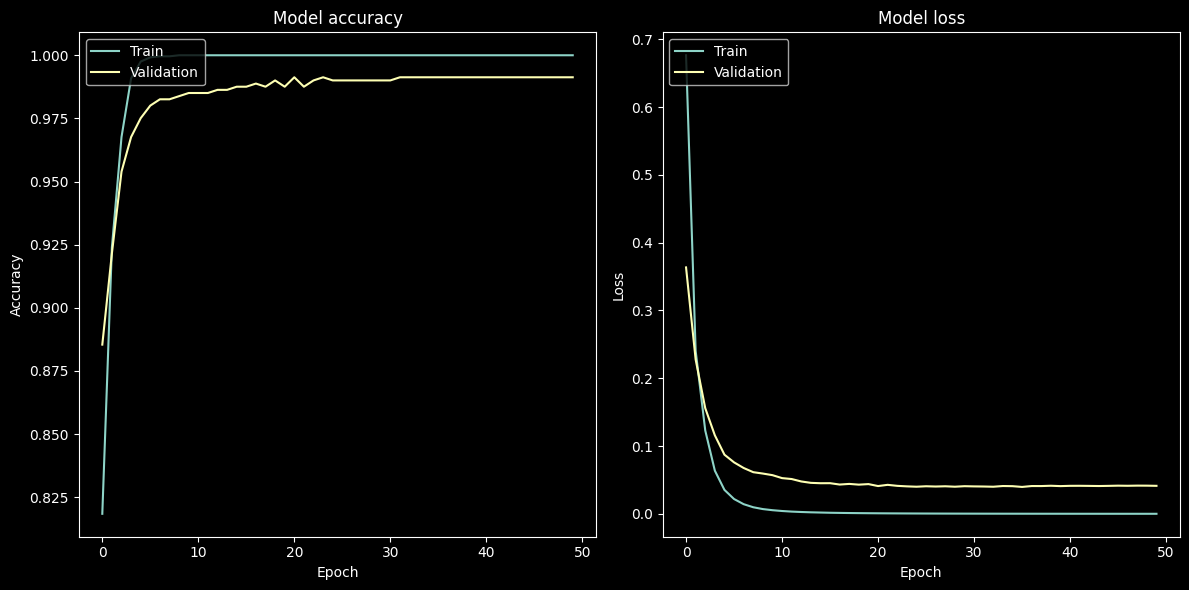

In [89]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## Visualizar las predicciones

Puedes usar un informe de clasificación y una matriz de confusión para visualizar el rendimiento del modelo en el conjunto de pruebas.

In [90]:
# Primero, hagamos las predicciones:

y_pred_probs = model.predict(X_test_preprocessed)
y_pred = np.argmax(y_pred_probs, axis=1)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 # Primero, hagamos las predicciones:                                                         │
│   2                                                                                              │
│ ❱ 3 y_pred_probs = model.predict(X_test_preprocessed)                                            │
│   4 y_pred = np.argmax(y_pred_probs, axis=1)                                                     │
│   5                                                                                              │
│                                                                                                  │
│ c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data                                      │
│ Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages\keras\src\utils\traceback │
│ _utils.py:70 in error_handler                                                                    │
│                                                                                                  │
│    67 │   │   │   filtered_tb = _process_traceback_frames(e.__traceback__)                       │
│    68 │   │   │   # To get the full stack trace, call:                                           │
│    69 │   │   │   # `tf.debugging.disable_traceback_filtering()`                                 │
│ ❱  70 │   │   │   raise e.with_traceback(filtered_tb) from None                                  │
│    71 │   │   finally:                                                                           │
│    72 │   │   │   del filtered_tb                                                                │
│    73                                                                                            │
│                                                                                                  │
│ C:\Users\PABLOV~1\AppData\Local\Temp\__autograph_generated_filegwa8irw9.py:15 in                 │
│ tf__predict_function                                                                             │
│                                                                                                  │
│   12 │   │   │   │   retval_ = ag__.UndefinedReturnValue()                                       │
│   13 │   │   │   │   try:                                                                        │
│   14 │   │   │   │   │   do_return = True                                                        │
│ ❱ 15 │   │   │   │   │   retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self)    │
│   16 │   │   │   │   except:                                                                     │
│   17 │   │   │   │   │   do_return = False                                                       │
│   18 │   │   │   │   │   raise                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: in user code:

    File "c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data 
Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages\keras\src\engine\training.py", line 2416, in
predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data 
Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages\keras\src\engine\training.py", line 2401, in
step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data 
Science\TFM\nuevo_entorno_kedro\TFM_HADO_Cares\.venv\lib\site-packages\keras\src\engine\training.py", line 2389, in
run_step  **
        outp

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00       261
           2       1.00      1.00      1.00       479
           3       1.00      1.00      1.00        33

    accuracy                           1.00       803
   macro avg       1.00      1.00      1.00       803
weighted avg       1.00      1.00      1.00       803



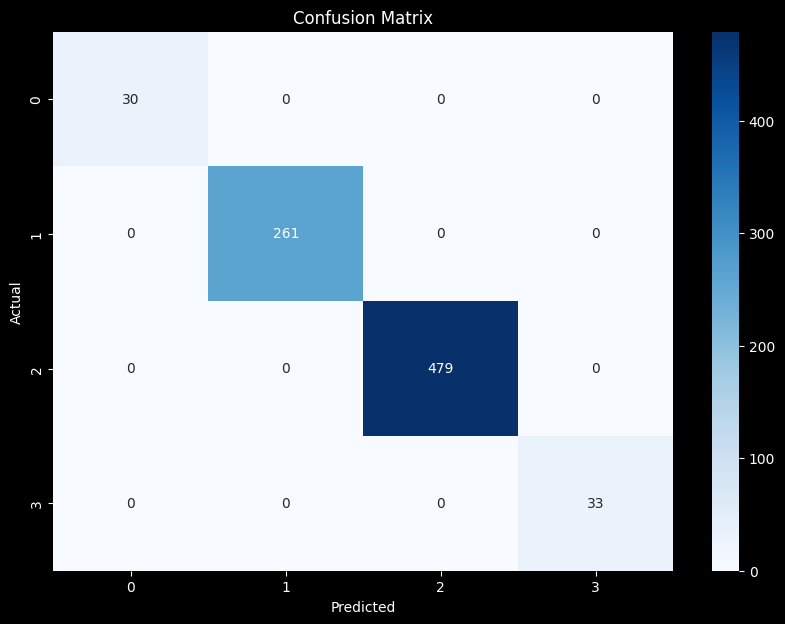

In [91]:
# Luego, visualiza el informe de clasificación y la matriz de confusión:


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_test_encoded, y_pred))

cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Visualización de la arquitectura del modelo

In [92]:
# Mostrar un resumen textual de la arquitectura del modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               309120    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 310410 (1.18 MB)
Trainable params: 310410 (1.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


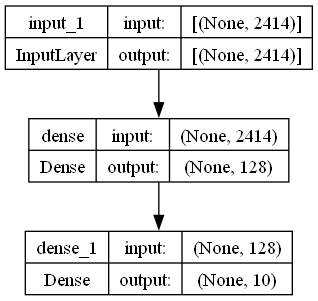

In [93]:
from keras.utils import plot_model

# Visualizar el modelo
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

## Visualización de activaciones intermedias

1/1 [==============================] - 0s 17ms/step


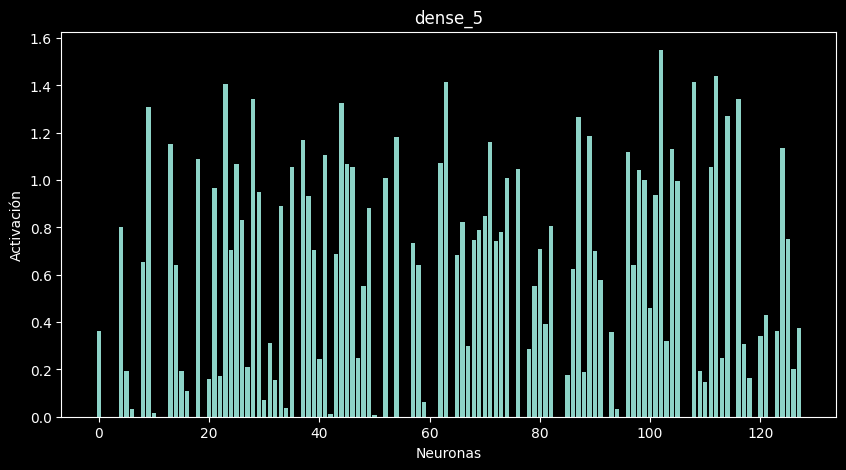

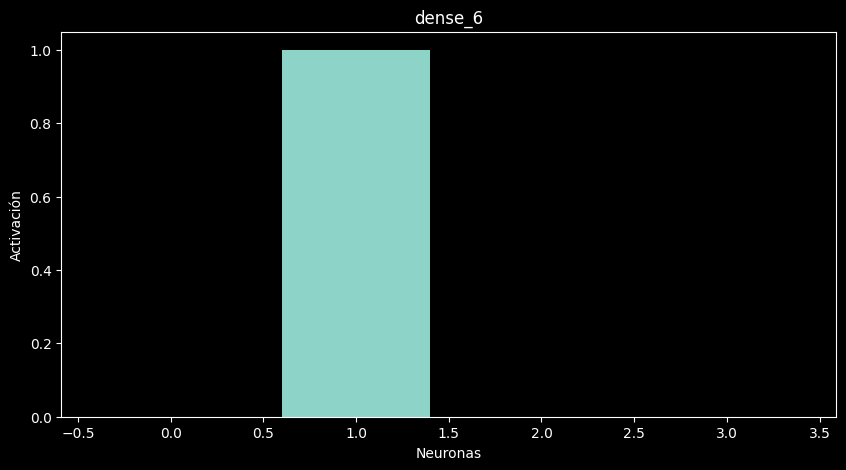

In [120]:
from keras.models import Model

# Extraer las salidas de las primeras 8 capas del modelo
layer_outputs = [layer.output for layer in model.layers[:8]]

# Crear un modelo que devuelva estas salidas dado los inputs del modelo
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Obtener las activaciones
activations = activation_model.predict(X_test_preprocessed[0].reshape(1, -1))  # usando el primer ejemplo del conjunto de prueba

# Visualizar las activaciones de las capas Densas
for layer_name, layer_activation in zip([layer.name for layer in model.layers[:8]], activations):
    # Las capas Densas tienen activaciones en forma (muestras, características)
    features = layer_activation[0]
    
    # Visualizar cada característica como una barra en un gráfico de barras
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(features)), features)
    plt.xlabel('Neuronas')
    plt.ylabel('Activación')
    plt.title(layer_name)
    plt.show()

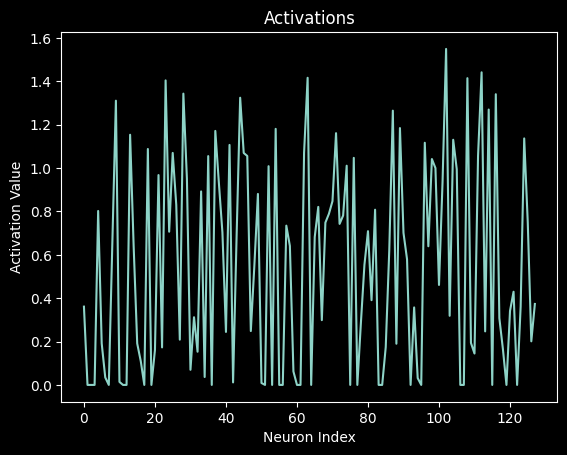

In [122]:
plt.plot(layer_activation[0])
plt.title('Activations')
plt.xlabel('Neuron Index')
plt.ylabel('Activation Value')
plt.show()


In [124]:
layer_activation


array([[0.36102122, 0.        , 0.        , 0.        , 0.802133  ,
        0.19130671, 0.0344955 , 0.        , 0.65338576, 1.3106695 ,
        0.01399296, 0.        , 0.        , 1.153626  , 0.63948727,
        0.19112755, 0.10977344, 0.        , 1.0879389 , 0.        ,
        0.16134979, 0.9677284 , 0.17302911, 1.4042594 , 0.70657957,
        1.069803  , 0.8304172 , 0.20877188, 1.3432794 , 0.9507567 ,
        0.06975333, 0.31213495, 0.15310442, 0.89230263, 0.03647686,
        1.0551833 , 0.        , 1.1712945 , 0.9321105 , 0.70316726,
        0.24431637, 1.1067258 , 0.0115914 , 0.688541  , 1.3243567 ,
        1.0696073 , 1.055774  , 0.24837944, 0.55100536, 0.8806832 ,
        0.0089209 , 0.        , 1.0086298 , 0.        , 1.1807971 ,
        0.        , 0.        , 0.7344676 , 0.64078295, 0.06199579,
        0.        , 0.        , 1.0709312 , 1.4162825 , 0.        ,
        0.6821652 , 0.8208913 , 0.2986585 , 0.7483533 , 0.78920496,
        0.8474386 , 1.1609302 , 0.74250805, 0.7

# 8.Visualización usando PCA o t-SNE

Estos métodos reducen la dimensionalidad de tus datos y pueden ayudarte a visualizar si tu modelo está separando bien las clases en el espacio de características.



In [129]:
activations


[
    array([[0.36102122, 0.        , 0.        , 0.        , 0.802133  ,
        0.19130671, 0.0344955 , 0.        , 0.65338576, 1.3106695 ,
        0.01399296, 0.        , 0.        , 1.153626  , 0.63948727,
        0.19112755, 0.10977344, 0.        , 1.0879389 , 0.        ,
        0.16134979, 0.9677284 , 0.17302911, 1.4042594 , 0.70657957,
        1.069803  , 0.8304172 , 0.20877188, 1.3432794 , 0.9507567 ,
        0.06975333, 0.31213495, 0.15310442, 0.89230263, 0.03647686,
        1.0551833 , 0.        , 1.1712945 , 0.9321105 , 0.70316726,
        0.24431637, 1.1067258 , 0.0115914 , 0.688541  , 1.3243567 ,
        1.0696073 , 1.055774  , 0.24837944, 0.55100536, 0.8806832 ,
        0.0089209 , 0.        , 1.0086298 , 0.        , 1.1807971 ,
        0.        , 0.        , 0.7344676 , 0.64078295, 0.06199579,
        0.        , 0.        , 1.0709312 , 1.4162825 , 0.        ,
        0.6821652 , 0.8208913 , 0.2986585 , 0.7483533 , 0.78920496,
        0.8474386 , 1.1609302 , 0.7425080

26/26 [==============================] - 0s 1ms/step


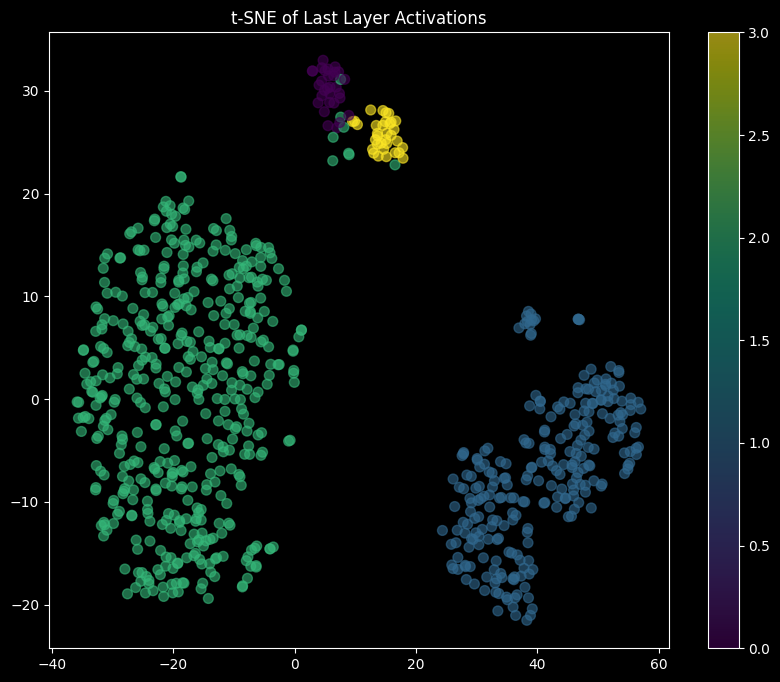

In [134]:
from sklearn.manifold import TSNE

# Crear una instancia de TSNE
tsne = TSNE(n_components=2)

# Obtener las activaciones de la última capa antes de la salida para todo el conjunto de prueba
all_activations = activation_model.predict(X_test_preprocessed)

# Tomar las activaciones de la penúltima capa
last_layer_activations = all_activations[-2]

# Usar t-SNE para reducir la dimensionalidad
reduced_activations = tsne.fit_transform(last_layer_activations)

# Visualizar
plt.figure(figsize=(10, 8))
plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], c=y_test_encoded, cmap='viridis', s=50, alpha=0.6)
plt.colorbar()
plt.title('t-SNE of Last Layer Activations')
plt.show()
